In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from collections import defaultdict
import re
import Levenshtein
from itertools import combinations
from scipy.stats import gmean
import profiler as pf

os.chdir('C:/Users/Admin/Documents/GitHub/Data-Guide')

In [3]:
input_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/transformed_feb_18" 

output_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/analyses_feb_18"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the data
csv_files = {
        "aged_AR" : os.path.join(input_dir, "transformed_aged_AR.csv"),
        # "statement_submission" : os.path.join(input_dir, "statement_submission_report.csv"),
         "integrated_payments" : os.path.join(input_dir, "transformed_integrated_payments.csv"),
        #"billing_statement" : os.path.join(input_dir, "billing_statement_report.csv"),
        # "outstanding_claims" : os.path.join(input_dir, "outstanding_claims_report.csv"),
        # "unresolved_claims" : os.path.join(input_dir, "unresolved_claims_report.csv"),
        #"fee_schedule" : os.path.join(input_dir, "fee_schedule.csv"),
        #"openings" : os.path.join(input_dir,"openings.csv"),
        #"schedule" : os.path.join(input_dir,"schedule.csv"),
        "patient_list" : os.path.join(input_dir, "transformed_patient_details.csv"),
        # "processed_payments": os.path.join(input_dir, "ZR - Credit Card Processed Payments.csv"),
        "transaction_details" : os.path.join(input_dir, "transformed_transaction_details.csv"),
        "charges" : os.path.join(input_dir, "transformed_incurred_charges.csv"),
        # "treatment_tracker" : os.path.join(input_dir, "ZR - Treatment Tracker.csv"),
    }

 # Load datasets
dataframes = {dataset: pd.read_csv(file_path) for dataset, file_path in csv_files.items()}

In [4]:
def curve(x, n = 2):
    return round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), n)

# Patient Data Only

## Initial processing and simple checks

In [5]:
patients = dataframes["patient_list"]

patients['surviving'] = (patients['Status'] == 'ACTIVE') | (pd.to_datetime(patients['Last Visit']) > (pd.Timestamp.today() - pd.DateOffset(years=1)))

In [6]:
patients['surviving'].value_counts()

surviving
True     940
False    919
Name: count, dtype: int64

In [7]:
# Find those who only have one visit

patients['lone_vist'] = patients['Last Visit'] == patients['First Visit']
patients['lone_vist'].value_counts()

lone_vist
False    1635
True      224
Name: count, dtype: int64

In [8]:
patients['lifespan'] = patients.apply(lambda row: max((pd.Timestamp.today() - pd.to_datetime(row['First Visit'])).days, 
                                                      (pd.to_datetime(row['Next Appointment Date']) - pd.to_datetime(row['First Visit'])).days) 
                                      if row['surviving'] else 
                                      (pd.to_datetime(row['Last Visit']) - pd.to_datetime(row['First Visit'])).days, axis=1)

In [9]:
temporal = pf.TemporalAnalyzer(patients, output_dir)
plotters = pf.DataProfilerPlots(patients)

In [10]:
numeric = pf.NumericProfiler(patients['lifespan'])
numeric.profile()

{'total': 760372.0,
 'distinct_values': 762,
 'statistics': {'count': 1492.0,
  'mean': 509.63,
  'std': 448.98,
  'min': 0.0,
  '1%': 0.0,
  '5%': 0.0,
  '33%': 189.0,
  '50%': 406.0,
  '66%': 652.06,
  '95%': 1379.0,
  '99%': 1607.18,
  'max': 1686.0},
 'skewness': 0.69,
 'kurtosis': -0.57,
 'most_common': {0.0: 144, 182.0: 19, 1.0: 17, 189.0: 14},
 'least_common': {1034.0: 1, 468.0: 1, 232.0: 1, 287.0: 1},
 'outliers': [],
 'count_negative': 0,
 'count_zero': 144,
 'avg_nonzero': 564.0741839762611,
 'count_blank': 367}

In [11]:
plotters.histogram('lifespan', f"{output_dir}/lifespan_hist.png")
plotters.kde_plot('lifespan', f"{output_dir}/lifespan_kde.png")
plotters.box_plot('lifespan', f"{output_dir}/lifespan_box.png")

In [12]:
patients['Cleaned Carrier'].value_counts().head(30)

Cleaned Carrier
Delta Dental                                   352
Blue Cross Blue Shield                         235
MetLife                                        220
Aetna                                          145
Guardian                                       136
CIGNA Global Health                            131
United Healthcare Dental                        97
Humana                                          24
Sun Life Financial (PO Box 2940 Clinton IA)     20
Principal Financial Group                       17
Unum (Administered by Starmount)                10
Principal Life Insurance Company                 9
UMR- Wausau /UHIS                                7
Guardian Individual Plan                         6
Ameritas Life Insurance Corp                     6
BEAM Dental Insurance                            4
Anthem Blue Cross CA                             3
GEHA                                             3
United Concordia- Dental Plus                    3
US Health Group

In [13]:
carriers = ['Delta Dental', 'Blue Cross Blue Shield', 'MetLife', 'Aetna', 'Guardian','CIGNA Global Health', 'United Healthcare Dental', 'Humana', 'Sun Life Financial (PO Box 2940 Clinton IA)', 'Principal Financial Group', 'Unum (Administered by Starmount)']

In [14]:
patients['carrier'] = patients['Cleaned Carrier'].apply(lambda x: x if x in carriers else 'OTHER')
patients['carrier'].value_counts()

carrier
OTHER                                          472
Delta Dental                                   352
Blue Cross Blue Shield                         235
MetLife                                        220
Aetna                                          145
Guardian                                       136
CIGNA Global Health                            131
United Healthcare Dental                        97
Humana                                          24
Sun Life Financial (PO Box 2940 Clinton IA)     20
Principal Financial Group                       17
Unum (Administered by Starmount)                10
Name: count, dtype: int64

In [15]:
patients['ZIP'] = patients['ZIP Code'].apply(lambda x: x if x in ['60640', '60613', '60625', '60618'] else 'OTHER')
patients['ZIP'].value_counts()

ZIP
60640    1121
OTHER     303
60613     185
60625     168
60618      82
Name: count, dtype: int64

In [16]:
patients['DCS'] = patients['Pat. Prim. Plan'].str.contains('DCS')
patients['DNU'] = patients['Pat. Prim. Plan'].str.contains('DNU')

In [17]:
patients.loc[(patients['lifespan'].isna()) & (patients['Status'].isin(['ACTIVE', 'INACTIVE'])) & (~patients['First Visit'].isna())].drop(columns=['Patient', 'Primary Guarantor', 'Primary Contact', 'Last Name', 'Chart Number', 'Ascend Patient ID', 'Date Of Birth', 'Phone', 'Email', 'Address']).head(30)

,Status,First Visit,Last Visit,Last Procedure Date,Next Appointment Date,Discount Plan,Pat. Prim. Fee Schedule,Pat. Prim. Carrier,Pat. Prim. Plan,Prim. Subscriber ID,...,plan_name,plan_name_cruft,university_or_college_plan,Simplest_Equivalent_Plan,plan_name_diff,surviving,lone_vist,lifespan,carrier,ZIP
67,INACTIVE,2021-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60625
357,INACTIVE,2020-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,OTHER
406,INACTIVE,2023-02-22,NaN,NaN,NaN,NaN,Careington Care Platinum PPO 2025,MetLife,Johann,200893,...,Johann,NaN,False,johann,NaN,False,False,NaN,MetLife,OTHER
674,INACTIVE,2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60640
762,INACTIVE,2021-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60640
822,INACTIVE,2021-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,60640
1836,INACTIVE,2021-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,False,False,NaN,OTHER,OTHER


In [18]:
patients.loc[(patients['lifespan'].isna()) & (patients['Status'].isin(['ACTIVE', 'INACTIVE'])) & (~patients['First Visit'].isna()), 'lifespan'] = 0

In [19]:
prediction_columns = ['surviving', 'lone_vist', 'lifespan', 'Discount Plan', 'Pat. Prim. Fee Schedule', 'carrier', 'ZIP', 'student', 'patientAge', 'DCS', 'DNU']

## Survival Analyses

In [20]:
return_df = patients.loc[(patients['First Visit'] < '2024-02-01') & (patients['Status'].isin(['ACTIVE', 'INACTIVE'])) & (~patients['First Visit'].isna()), prediction_columns].copy()
survival_df = patients.loc[(patients['Status'].isin(['ACTIVE', 'INACTIVE']) & (~patients['First Visit'].isna())), prediction_columns].copy()

In [21]:
return_df

,surviving,lone_vist,lifespan,Discount Plan,Pat. Prim. Fee Schedule,carrier,ZIP,student,patientAge,DCS,DNU
3,True,False,1090.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,43.0,False,False
4,True,False,791.0,NaN,Delta Dental Premier,Delta Dental,60625,Non-Student,49.0,True,False
5,False,False,64.0,NaN,Careington Care Platinum PPO 2025,United Healthcare Dental,60640,Non-Student,46.0,False,True
6,False,False,41.0,NaN,Careington Care Platinum PPO 2025,United Healthcare Dental,60640,Non-Student,47.0,False,False
7,True,False,987.0,NaN,Careington Care Platinum PPO 2025,MetLife,60640,Non-Student,31.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1851,False,True,0.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,45.0,False,True
1852,True,False,1030.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,28.0,False,False
1853,False,False,28.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60613,Non-Student,33.0,False,False
1855,True,False,742.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,40.0,False,False


In [22]:
survival_df

,surviving,lone_vist,lifespan,Discount Plan,Pat. Prim. Fee Schedule,carrier,ZIP,student,patientAge,DCS,DNU
0,True,False,264.0,NaN,Careington Care Platinum PPO 2025,Aetna,60625,Non-Student,44.0,True,True
1,True,False,151.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,39.0,False,False
3,True,False,1090.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60640,Non-Student,43.0,False,False
4,True,False,791.0,NaN,Delta Dental Premier,Delta Dental,60625,Non-Student,49.0,True,False
5,False,False,64.0,NaN,Careington Care Platinum PPO 2025,United Healthcare Dental,60640,Non-Student,46.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...
1852,True,False,1030.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,28.0,False,False
1853,False,False,28.0,NaN,Careington Care Platinum PPO 2025,Blue Cross Blue Shield,60613,Non-Student,33.0,False,False
1855,True,False,742.0,NaN,Delta Dental Premier,Delta Dental,60640,Non-Student,40.0,False,False
1856,True,False,180.0,NaN,Delta Dental TOA 2025 STATE OF IL-QCDP,Delta Dental,60640,Non-Student,60.0,False,False


In [23]:
numeric = pf.NumericProfiler(survival_df['lifespan'])
numeric.profile()

{'total': 758012.0,
 'distinct_values': 760,
 'statistics': {'count': 1485.0,
  'mean': 510.45,
  'std': 449.04,
  'min': 0.0,
  '1%': 0.0,
  '5%': 0.0,
  '33%': 189.0,
  '50%': 406.0,
  '66%': 654.32,
  '95%': 1379.0,
  '99%': 1607.32,
  'max': 1686.0},
 'skewness': 0.68,
 'kurtosis': -0.57,
 'most_common': {0.0: 146, 182.0: 19, 1.0: 16, 7.0: 13},
 'least_common': {217.0: 1, 1141.0: 1, 105.0: 1, 287.0: 1},
 'outliers': [],
 'count_negative': 0,
 'count_zero': 146,
 'avg_nonzero': 566.1030619865571,
 'count_blank': 0}

In [24]:
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter

<Axes: xlabel='timeline'>

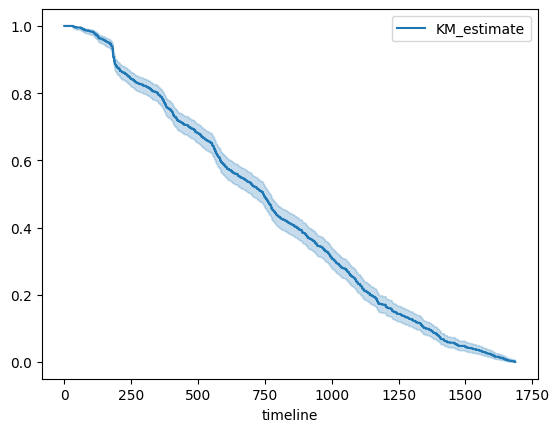

In [25]:
# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(survival_df['lifespan'], event_observed=survival_df['surviving'])

# Plot survival curve
kmf.plot_survival_function()

In [26]:
s_df = pd.get_dummies(survival_df, drop_first=True).drop(columns=['lone_vist'])
s_df

,surviving,lifespan,patientAge,Discount Plan_Employee Dental Plan,Discount Plan_Wellness - I,Pat. Prim. Fee Schedule_AlwaysCare,Pat. Prim. Fee Schedule_CIGNA 2022 Z219,Pat. Prim. Fee Schedule_Careington Care Platinum PPO 2025,Pat. Prim. Fee Schedule_Delta Dental Premier,Pat. Prim. Fee Schedule_Delta Dental TOA 2025 STATE OF IL-QCDP,...,carrier_Sun Life Financial (PO Box 2940 Clinton IA),carrier_United Healthcare Dental,carrier_Unum (Administered by Starmount),ZIP_60618,ZIP_60625,ZIP_60640,ZIP_OTHER,student_Student,DCS_True,DNU_True
0,True,264.0,44.0,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,True
1,True,151.0,39.0,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,True,1090.0,43.0,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,True,791.0,49.0,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
5,False,64.0,46.0,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,True,1030.0,28.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1853,False,28.0,33.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1855,True,742.0,40.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1856,True,180.0,60.0,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column Discount Plan_Employee Dental Plan have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['surviving'].astype(bool)
>>> print(df.loc[events, 'Discount Plan_Employee Dental Plan'].var())
>>> print(df.loc[~events, 'Discount Plan_Employee Dental Plan'].var())

A very low variance means that the column Discount Plan_Employee Dental Plan completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

<lifelines.CoxPHFitter: fitted with 1485 total observations, 551 right-censored observations>
             duration col = 'lifespan'
                event col = 'surviving'
      baseline estimation = breslow
   number of observations = 1485
number of events observed = 934
   partial log-likelihood = -5505.14
         time fit was run = 2025-03-18 18:58:59 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
patientAge                                                      -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
Discount Plan_Employee Dental Plan                              -0.10      0.90      0.60           -1.28            1.07                0.28                2.91
Discount Plan_Wellness - I                                       0.09      1.10      0.21           -0.32            0.51                0.73                1.66
Pat. Prim. Fee Schedule_AlwaysCare                              11.85  1.40e+05    660.38        -1282.48         1306.17                0.00                 inf
Pat. Prim. Fee Schedule_CIGNA 2022 Z219                         -0.41      0.66      0.59           -1.57            0.74                0.21                2.10
Pat. Prim. Fee Schedule_Careington Care Platinum PPO 2025        0.04      1.04      0.17           -0.29            0.38                0.75                1.46
Pat. Prim. Fee Schedule_Delta Dental Premier                    -0.73      0.48      0.53           -1.77            0.31                0.17                1.36
Pat. Prim. Fee Schedule_Delta Dental TOA 2025 STATE OF IL-QCDP  -0.84      0.43      0.59           -1.99            0.31                0.14                1.36
Pat. Prim. Fee Schedule_Dental Health Alliance                  -0.11      0.90      0.53           -1.14            0.93                0.32                2.54
carrier_Blue Cross Blue Shield                                   0.05      1.05      0.14           -0.22            0.32                0.80                1.38
carrier_CIGNA Global Health                                      0.35      1.42      0.61           -0.85            1.55                0.43                4.69
carrier_Delta Dental                                             0.72      2.05      0.55           -0.37            1.81                0.69                6.09
carrier_Guardian                                                -0.08      0.92      0.16           -0.40            0.24                0.67                1.27
carrier_Humana                                                   0.35      1.42      0.28           -0.19            0.89                0.82                2.44
carrier_MetLife                                                 -0.08      0.93      0.14           -0.36            0.20                0.70                1.22
carrier_OTHER                                                   -0.25      0.78      0.21           -0.66            0.15                0.52                1.17
carrier_Principal Financial Group                               -0.23      0.80      0.49           -1.19            0.74                0.30                2.10
carrier_Sun Life Financial (PO Box 2940 Clinton IA)              0.49      1.63      0.59           -0.67            1.64                0.51                5.16
carrier_United Healthcare Dental                                -0.26      0.77      0.18           -0.61            0.09                0.54                1.10
carrier_Unum (Administered by Starmount)                       -12.08      0.00    660.38        -1306.41         1282.24                0.00                 inf
ZIP_60618                                                       -0.0

<Axes: xlabel='log(HR) (95% CI)'>

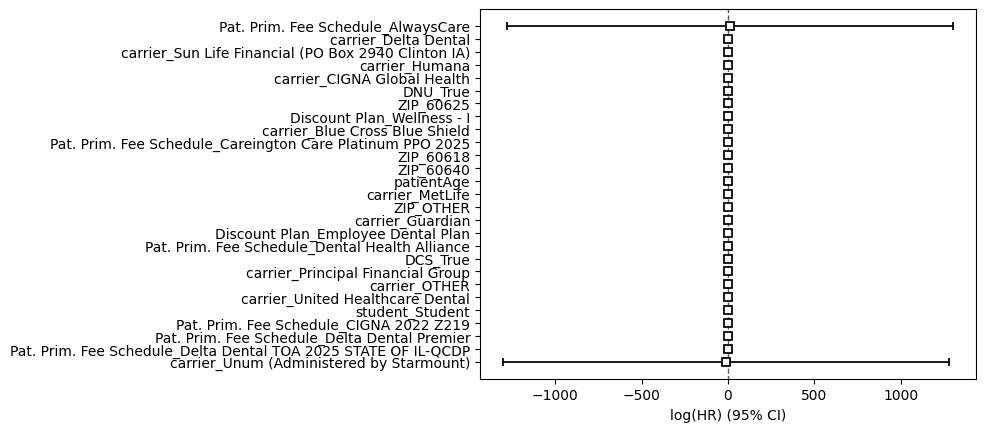

In [27]:
# Fit Cox model
cph = CoxPHFitter()
cph.fit(s_df, duration_col='lifespan', event_col='surviving')

# Print results and plot
cph.print_summary()
cph.plot()

<lifelines.CoxPHFitter: fitted with 1485 total observations, 551 right-censored observations>
             duration col = 'lifespan'
                event col = 'surviving'
      baseline estimation = breslow
   number of observations = 1485
number of events observed = 934
   partial log-likelihood = -5514.65
         time fit was run = 2025-03-18 18:59:00 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
patientAge     -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
DCS_True       -0.16      0.85      0.07           -0.30           -0.03                0.74                0.97
DNU_True        0.16      1.18      0.08            0.01            0.32                1.01                1.37
carrier_Humana  0.43      1.54      0.25           -0.06            0.92                0.94                2.50

                cmp to     z      p  -log2(p)
covariate                                    
patientAge        0.00 -5.30 <0.005     23.02
DCS_True          0.00 -2.36   0.02      5.79
DNU_True          0.00  2.07   0.04      4.69
carrier_Humana    0.00  1.73   0.08      3.58
---
Concordance = 0.57
Partial AIC = 11037.30
log-likelihood ratio test = 39.39 on 4 df
-log2(p) of ll-ratio test = 24.04

<Axes: xlabel='log(HR) (95% CI)'>

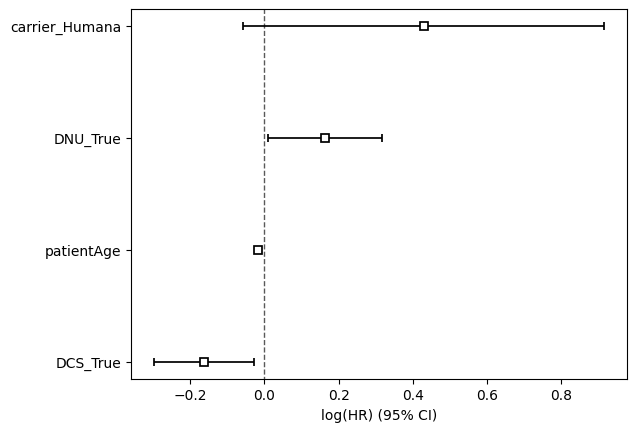

In [28]:
# Fit Cox model
cph = CoxPHFitter()
cph.fit(s_df.loc[:,['surviving','lifespan', 'patientAge', 'DCS_True', 'DNU_True', 'carrier_Humana']], duration_col='lifespan', event_col='surviving')

# Print results and plot
cph.print_summary()
cph.plot()

## Survival Curves

In [29]:
s_df2 = survival_df.copy()

# Convert categorical predictors to strings for stratification
columns_to_convert = ['Discount Plan', 'carrier', 'Pat. Prim. Fee Schedule', 'ZIP', 'student', 'DCS', 'DNU']
s_df2[columns_to_convert] = s_df2[columns_to_convert].apply(lambda x: x.astype(str))

# Create age bins for Kaplan-Meier stratification
s_df2['Age Group'] = pd.cut(s_df2['patientAge'], bins=[18, 30, 50, 80], labels=["18-30", "30-50", "50+"])

In [30]:
def plot_km_survival(df, time_col, event_col, group_col):
    """
    Plots Kaplan-Meier survival curves stratified by a categorical column.

    Args:
        df (pd.DataFrame): The dataframe containing survival data.
        time_col (str): The column representing duration/time.
        event_col (str): The column representing event occurrence (1 = event, 0 = censored).
        group_col (str): The categorical column to stratify by.
    
    Returns:
        None (Displays the survival plot)
    """
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    for category in df[group_col].dropna().unique():
        subset = df[df[group_col] == category]
        kmf.fit(subset[time_col], event_observed=subset[event_col], label=str(category))
        kmf.plot_survival_function()

    plt.title(f"Kaplan-Meier Survival Curve by {group_col}")
    plt.xlabel("Time (Days)")
    plt.ylabel("Survival Probability")
    plt.legend(title=group_col)
    plt.grid(True)
    plt.show()

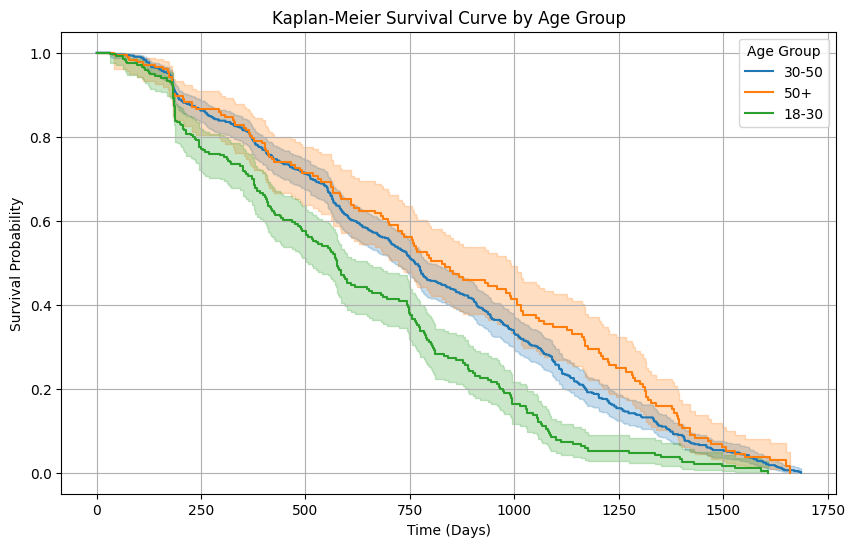

In [31]:
plot_km_survival(s_df2,'lifespan', 'surviving', 'Age Group')

In [32]:
carriers = ['Delta Dental', 'Blue Cross Blue Shield', 'MetLife']
s_df2['carrier'] = s_df2['carrier'].apply(lambda x: x if x in carriers else 'OTHER')
s_df2['carrier'].value_counts()

carrier
OTHER                     770
Delta Dental              309
Blue Cross Blue Shield    208
MetLife                   198
Name: count, dtype: int64

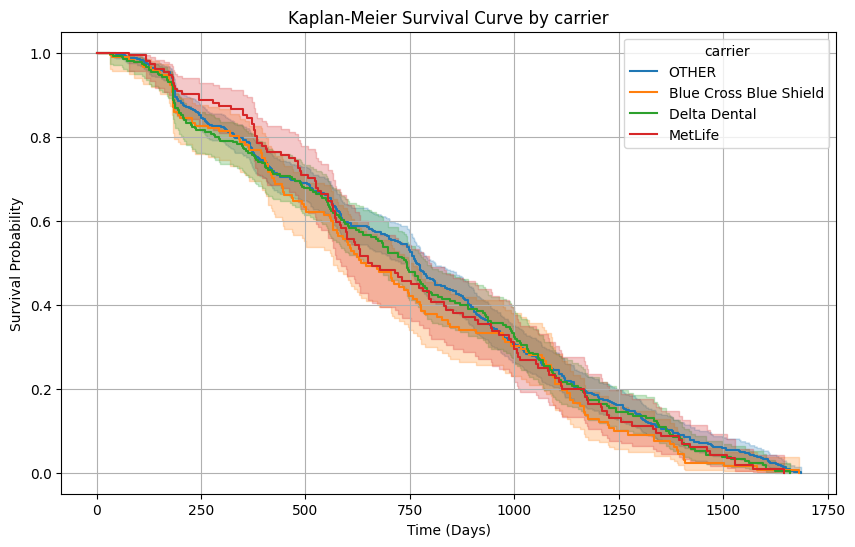

In [33]:
# columns_to_convert = ['Discount Plan', 'carrier', 'Pat. Prim. Fee Schedule', 'ZIP', 'student', 'DCS', 'DNU']
plot_km_survival(s_df2,'lifespan', 'surviving', 'carrier')

In [34]:
s_df2['Pat. Prim. Fee Schedule'].value_counts()

Pat. Prim. Fee Schedule
Careington Care Platinum PPO 2025         760
Delta Dental Premier                      293
nan                                       210
CIGNA 2022 Z219                           108
 Juniper Office Fees                       64
Dental Health Alliance                     25
Delta Dental TOA 2025 STATE OF IL-QCDP     18
AlwaysCare                                  7
Name: count, dtype: int64

In [35]:
fee_schedules = ['Careington Care Platinum PPO 2025', 'Delta Dental Premier', 'CIGNA 2022 Z219', ' Juniper Office Fees']
s_df2['fee_schedule'] = s_df2['Pat. Prim. Fee Schedule'].apply(lambda x: x if x in fee_schedules else 'OTHER or None')
s_df2['fee_schedule'].value_counts()

fee_schedule
Careington Care Platinum PPO 2025    760
Delta Dental Premier                 293
OTHER or None                        260
CIGNA 2022 Z219                      108
 Juniper Office Fees                  64
Name: count, dtype: int64

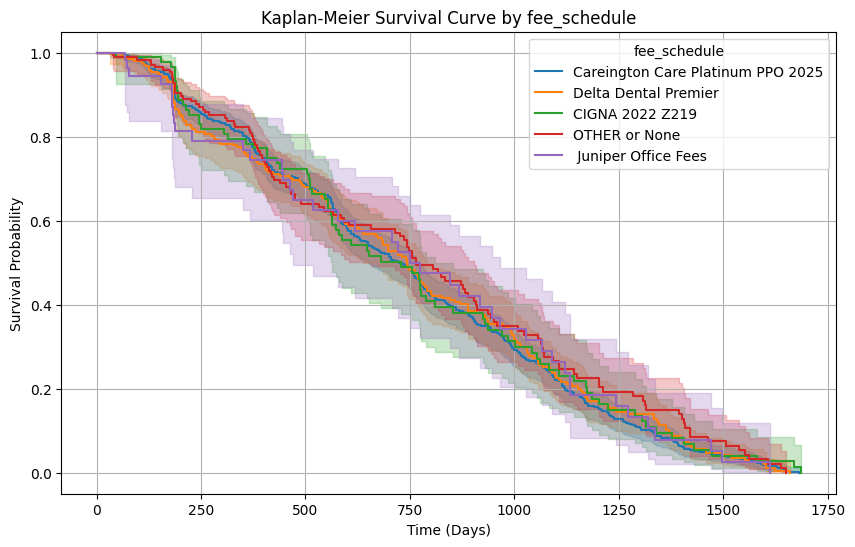

In [36]:
# columns_to_convert = ['Discount Plan', 'carrier', 'Pat. Prim. Fee Schedule', 'ZIP', 'student', 'DCS', 'DNU']
plot_km_survival(s_df2,'lifespan', 'surviving', 'fee_schedule')

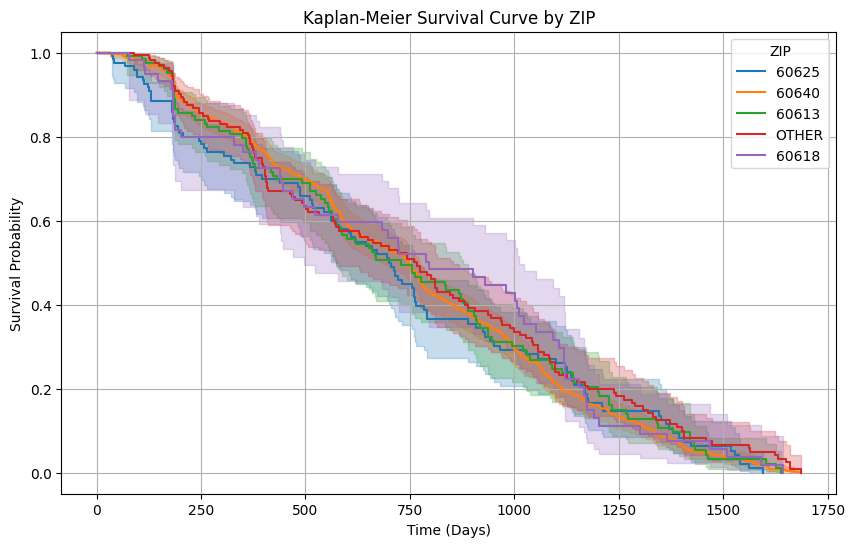

In [37]:
plot_km_survival(s_df2,'lifespan', 'surviving', 'ZIP')

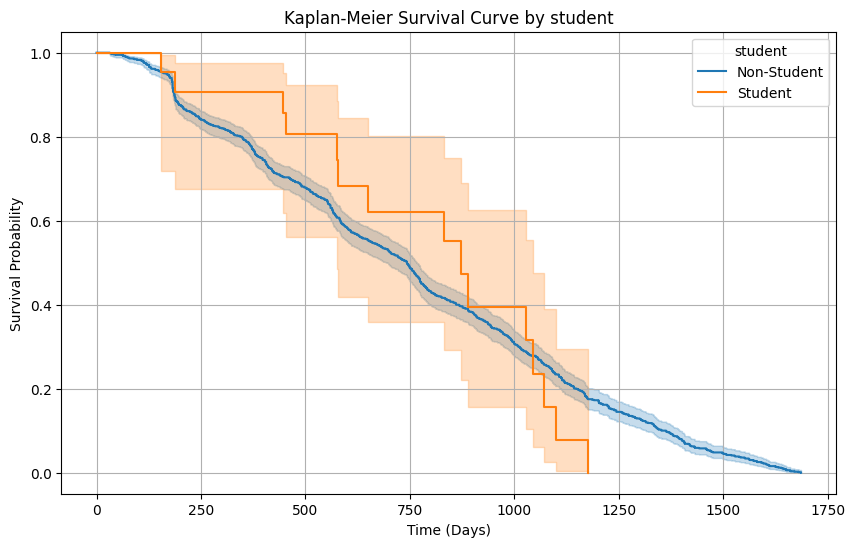

In [38]:
plot_km_survival(s_df2,'lifespan', 'surviving', 'student')

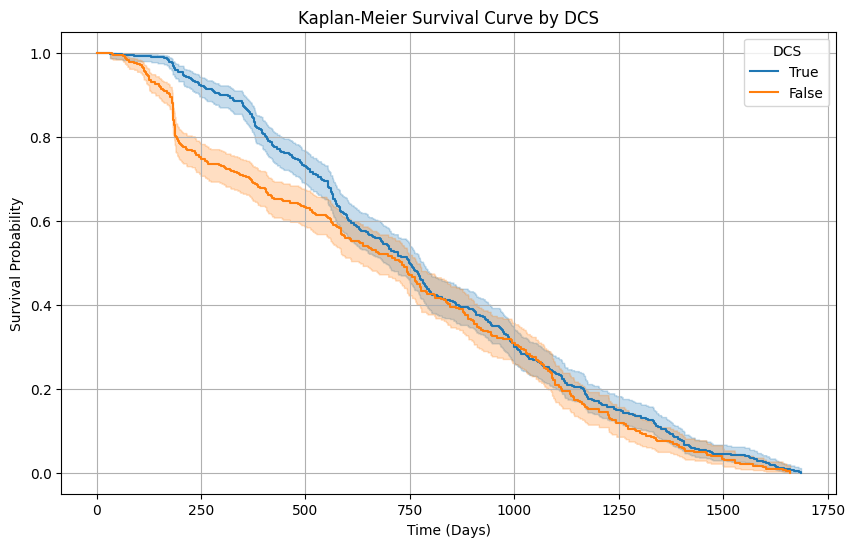

In [39]:
plot_km_survival(s_df2.loc[s_df2['DCS'] != 'nan'],'lifespan', 'surviving', 'DCS')

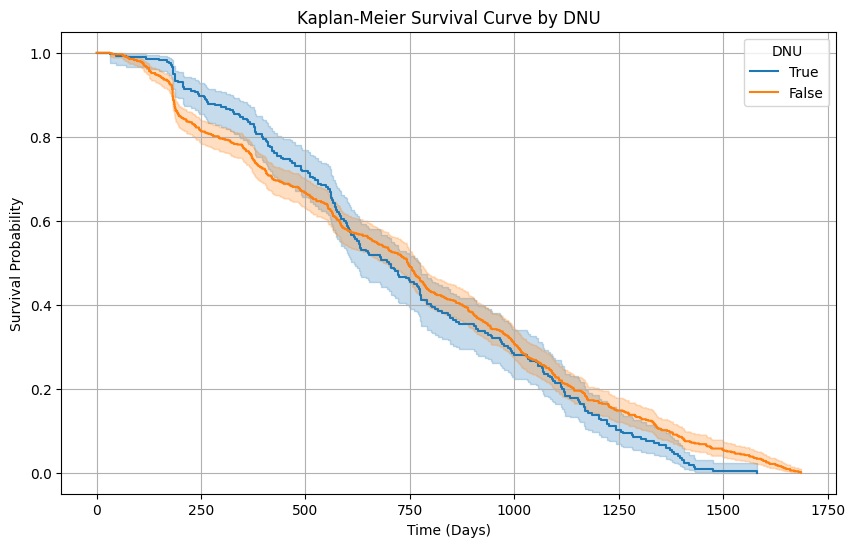

In [40]:
plot_km_survival(s_df2.loc[s_df2['DNU'] != 'nan'],'lifespan', 'surviving', 'DNU')

# Transaction & Charges 


## Processing

In [41]:
transactions = dataframes["transaction_details"].copy()
charges = dataframes["charges"].copy()

In [42]:
charges

,Ascend Patient ID,Patient,Date (Modified),Card Holder,Card Type,Transaction ID,Card Source,Reference Number,Transaction Type,Amount,sort_key,Days Between,Rolling Days Between,Running Total
0,14000002286402,"Intagliata, Emily",2022-11-01,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-364.0,0,NaN,0.0,-364.0
1,14000002286402,"Intagliata, Emily",2024-01-02,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-197.0,0,131.0,0.0,-80.5
2,14000002286402,"Intagliata, Emily",2024-07-05,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-239.0,0,169.0,0.0,-122.5
3,14000002286402,"Intagliata, Emily",2024-07-25,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-738.0,0,8.0,0.0,-621.5
4,14000002286402,"Intagliata, Emily",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-280.0,0,111.0,0.0,-163.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,14000008899060,"Kolasa, Mark",2025-01-30,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-974.0,0,NaN,0.0,-974.0
4921,14000008899060,"Kolasa, Mark",2025-02-04,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-193.0,0,5.0,0.0,-193.0
4922,14000008907565,"Dexter, Sonya",2025-02-05,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-1007.0,0,NaN,0.0,-1007.0
4923,14000008909950,"Lurbur, Hadassah",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,-474.0,0,NaN,0.0,-474.0


In [43]:
charges['Amount'] = charges['Amount']*-1
charges['Date'] = pd.to_datetime(charges['Date (Modified)'])
charges = charges[charges['Amount'] > 0]

In [44]:
charges

,Ascend Patient ID,Patient,Date (Modified),Card Holder,Card Type,Transaction ID,Card Source,Reference Number,Transaction Type,Amount,sort_key,Days Between,Rolling Days Between,Running Total,Date
0,14000002286402,"Intagliata, Emily",2022-11-01,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,364.0,0,NaN,0.0,-364.0,2022-11-01
1,14000002286402,"Intagliata, Emily",2024-01-02,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,197.0,0,131.0,0.0,-80.5,2024-01-02
2,14000002286402,"Intagliata, Emily",2024-07-05,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,239.0,0,169.0,0.0,-122.5,2024-07-05
3,14000002286402,"Intagliata, Emily",2024-07-25,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,738.0,0,8.0,0.0,-621.5,2024-07-25
4,14000002286402,"Intagliata, Emily",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,280.0,0,111.0,0.0,-163.5,2025-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,14000008899060,"Kolasa, Mark",2025-01-30,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,974.0,0,NaN,0.0,-974.0,2025-01-30
4921,14000008899060,"Kolasa, Mark",2025-02-04,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,193.0,0,5.0,0.0,-193.0,2025-02-04
4922,14000008907565,"Dexter, Sonya",2025-02-05,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,1007.0,0,NaN,0.0,-1007.0,2025-02-05
4923,14000008909950,"Lurbur, Hadassah",2025-02-03,Not Available,Not Available,Not Available,Not Available,Not Available: spaces etc.,Not Available,474.0,0,NaN,0.0,-474.0,2025-02-03


In [45]:
charge_data = charges.groupby('Ascend Patient ID').agg({
    "Amount": [
        ("Total Charges", lambda x: x.sum()), 
        ("Average Charge", lambda x: x.mean().round()), 
        ("Max Charge", lambda x: x.max())
    ],
    "Date": [
        ("Number of Charges", lambda x: x.count()), 
        ("First Charge Date", lambda x: x.min()), 
        ("Last Charge Date", lambda x: x.max()), 
        ("Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    charges_per_year=lambda d: ( # Change to # Semiannual Charges
        (d[("Date", "Number of Charges")] * 365 / d[("Date", "Timespan")])
        .where(d[("Date", "Timespan")] > 365, d[("Date", "Number of Charges")])  # Fix for division by zero 
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

charge_data

Amount                                        Date  \
                  Total Charges Average Charge Max Charge Number of Charges   
Ascend Patient ID                                                             
14000002286402           1818.0          364.0      738.0                 5   
14000002286403           1090.0          363.0      529.0                 3   
14000002286404           3081.0          440.0     1399.0                 7   
14000002286406           6187.0          562.0     3054.0                11   
14000002286407            561.0          280.0      364.0                 2   
...                         ...            ...        ...               ...   
14000008880368            474.0          474.0      474.0                 1   
14000008899060           1167.0          584.0      974.0                 2   
14000008907565           1007.0         1007.0     1007.0                 1   
14000008909950            474.0          474.0      474.0                 1   
14000008928017            500.0          500.0      500.0                 1   

                                                              charges_per_year  
                  First Charge Date Last Charge Date Timespan                   
Ascend Patient ID                                                               
14000002286402           2022-11-01       2025-02-03      825                2  
14000002286403           2022-11-17       2025-02-05      811                1  
14000002286404           2022-08-25       2024-11-14      812                3  
14000002286406           2023-01-03       2025-01-10      738                5  
14000002286407           2023-03-16       2023-09-19      187                2  
...                             ...              ...      ...              ...  
14000008880368           2025-02-04       2025-02-04        0                1  
14000008899060           2025-01-30       2025-02-04        5                2  
14000008907565           2025-02-05       2025-02-05        0                1  
14000008909950           2025-02-03       2025-02-03        0                1  
14000008928017           2025-02-04       2025-02-04        0                1  

[1244 rows x 8 columns]

In [46]:
charge_plotters = pf.DataProfilerPlots(charge_data)

In [47]:
for col in charge_data.select_dtypes(exclude=['datetime64[ns]']).columns:
    print(f"Numeric Profiling for {col}")
    print(pf.NumericProfiler(charge_data[col]).profile())
    print("\n")
    charge_plotters.histogram(col, f"{output_dir}/{col}_hist.png")

Numeric Profiling for ('Amount', 'Total Charges')
{'total': 2195779.05, 'distinct_values': 831, 'statistics': {'count': 1244.0, 'mean': 1765.1, 'std': 1587.02, 'min': 95.0, '1%': 190.16, '5%': 339.15, '33%': 917.95, '50%': 1338.0, '66%': 1881.52, '95%': 4647.45, '99%': 7765.8, 'max': 16174.0}, 'skewness': 2.68, 'kurtosis': 12.36, 'most_common': {430.0: 66, 364.0: 21, 627.0: 20, 197.0: 17}, 'least_common': {1552.0: 1, 3333.0: 1, 2152.0: 1, 500.0: 1}, 'outliers': [6187.0, 8144.0, 11267.0, 5419.0, 4809.0, 5638.0, 5368.0, 5993.0, 5357.0, 5571.0, 5202.0, 16174.0, 5829.1, 4889.0, 5673.0, 6057.0, 7783.0, 9164.0, 12710.0, 8130.0, 7500.0, 9839.0, 5485.0, 6800.0, 5878.0, 4995.0, 6236.0, 5144.0, 5277.0, 5831.0, 6918.0, 9633.0, 6440.0, 5433.0, 5342.0, 5725.0, 9135.0, 5522.0, 5017.0, 5904.0, 8237.0, 8363.0, 6117.0, 7682.0, 7743.0, 7090.0, 5080.0, 7175.0, 7153.0, 6164.0, 5151.0, 6112.0, 5160.0, 5602.25, 6156.25, 5456.0, 12346.0, 6814.0], 'count_negative': 0, 'count_zero': 0, 'avg_nonzero': 1765.0956

In [48]:
transactions['Date'] = pd.to_datetime(transactions['Date'])

procedures = transactions.loc[transactions['Category'] == 'Procedures'].copy()
insurance_payments = transactions.loc[transactions['Category'] == 'Insurance Payments'].copy()
guarantor_payments = transactions.loc[transactions['Category'] == 'Guarantor Payments'].copy()
adjustments = transactions.loc[transactions['Category'] == 'Credit Adjustments'].copy()

In [49]:
transactions

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
0,2019-10-27,"Gabriel, Rami",14000002286456,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2020-06-21,"Barrios, James",14000002286515,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,47.2,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2020-10-08,"Greene, David E",14000002286843,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2020-10-08,"Koenig, Cody",14000002286781,CK5152H,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,2020-10-20,"Reiman, Stephanie M",14000002286454,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53513,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0120,Periodic Evaluation,NaN,0.0,-42.0,...,False,False,False,False,False,False,False,False,False,False
53514,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0220,Intraoral Periapical Images,NaN,0.0,-22.5,...,False,False,False,False,False,False,False,False,False,False
53515,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0230,Intraoral Periapical Add'l,NaN,0.0,-21.6,...,False,False,False,False,False,False,False,False,False,False
53516,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0274,Bitewing Four Images,NaN,0.0,-7.2,...,False,False,False,False,False,False,False,False,False,False


In [50]:
procedures

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
5,2020-10-22,"Giles-spencer, Diane",14000002286826,Not Available,Procedures,D0180,Periodontal Evaluation,Mouth,134.0,0.0,...,False,False,False,False,False,False,False,False,False,False
6,2020-10-22,"Giles-spencer, Diane",14000002286826,Not Available,Procedures,D0210,Intraoral – comprehensive series of radiograph...,NaN,180.0,0.0,...,False,False,False,False,False,False,False,False,True,False
13,2021-01-05,"Wright, Ernest",14000002286528,Not Available,Procedures,D0180,Periodontal Evaluation,Mouth,134.0,0.0,...,False,False,False,False,False,False,False,False,False,False
14,2021-01-05,"Wright, Ernest",14000002286528,Not Available,Procedures,D0210,Intraoral – comprehensive series of radiograph...,NaN,180.0,0.0,...,False,False,False,False,False,False,False,False,True,False
15,2021-01-05,"Wright, Ernest",14000002286528,Not Available,Procedures,D1110,Prophylaxis - Adult,NaN,125.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53457,2025-02-18,"Khalaf, Christelle",14000006726528,Not Available,Procedures,D0274,Bitewing Four Images,Mouth,101.0,0.0,...,False,False,False,False,False,False,False,False,False,False
53509,2025-02-18,"Wilkins, Jennifer",14000007120519,JW5240H,Procedures,D0220,Intraoral Periapical Images,Th13,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
53510,2025-02-18,"Wilkins, Jennifer",14000007120519,JW5240H,Procedures,D0350,2D Oral/Facial Photo Images,Mouth,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
53511,2025-02-18,"Wilkins, Jennifer",14000007120519,JW5240H,Procedures,D2740,Full Porcelain/Ceramic Crown,Th13,1680.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [51]:
proc_words = ['evaluation', 'intraoral', 'periapical', 'prophylaxis', 'bitewing', 'resin', 'composite', 'images', 'posterior']
proc_types = {'Th7, Th8, Th9, Th10': "Th7-10", 'Th23, Th24, Th25, Th26': 'Th23-26', 'Mouth ': 'Mouth'}
# Take 'Th7, Th8, Th9, Th10', 'Th23, Th24, Th25, Th26', 'Mouth', and 'Other'
# 'Proc Treatment Area'
# Top 5 and Other
# 'Proc. Description'

In [52]:
proc_data = procedures.groupby('Ascend Patient ID').agg({
    "Charges": [
        ("Total Charges", lambda x: x.sum()), 
        ("Average Charge", lambda x: x.mean().round()), 
        ("Max Charge", lambda x: x.max())
    ],
    "Date": [
        ("Number of Procedures", lambda x: x.count()), 
        ("First Procedure Date", lambda x: x.min()), 
        ("Last Procedure Date", lambda x: x.max()), 
        ("Procedure Timespan", lambda x: (x.max()-x.min()).days)
    ],
    "Proc Treatment Area": [
        ("Top Treatment Area", lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        ("Number of Treatment Areas", lambda x: x.nunique())
    ],
}).pipe(lambda d: d.assign(
    procedures_per_year=lambda d: (
        (d[("Date", "Number of Procedures")] * 365 / d[("Date", "Procedure Timespan")])
        .where(d[("Date", "Procedure Timespan")] > 365, d[("Date", "Number of Procedures")])
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

# Apply 'Any {w} Procedure' checks safely
for w in proc_words:
    proc_data[(f"Any {w} Procedure")] = (
        procedures.groupby('Ascend Patient ID')[w]
        .apply(lambda x: x.any())
    )

proc_data


Charges                            \
                  Total Charges Average Charge Max Charge   
Ascend Patient ID                                           
14000002286402           2015.0          106.0      255.0   
14000002286403           3222.0          190.0     1527.0   
14000002286404           6316.0          197.0     1872.0   
14000002286405            439.0          146.0      180.0   
14000002286406           7916.0          226.0     1527.0   
...                         ...            ...        ...   
14000008880368            474.0           68.0      198.0   
14000008899060           1167.0           97.0      500.0   
14000008907565           1007.0          144.0      500.0   
14000008909950            474.0           59.0      198.0   
14000008928017            836.0          119.0      500.0   

                                  Date                       \
                  Number of Procedures First Procedure Date   
Ascend Patient ID                                             
14000002286402                      19           2022-04-20   
14000002286403                      17           2022-04-28   
14000002286404                      32           2021-09-30   
14000002286405                       3           2021-10-14   
14000002286406                      35           2022-02-10   
...                                ...                  ...   
14000008880368                       7           2025-02-04   
14000008899060                      12           2025-01-30   
14000008907565                       7           2025-02-05   
14000008909950                       8           2025-02-03   
14000008928017                       7           2025-02-04   

                                                         Proc Treatment Area  \
                  Last Procedure Date Procedure Timespan  Top Treatment Area   
Ascend Patient ID                                                              
14000002286402             2025-02-03               1020              Mouth    
14000002286403             2025-02-05               1014              Mouth    
14000002286404             2024-11-14               1141              Mouth    
14000002286405             2021-10-14                  0              Mouth    
14000002286406             2025-01-10               1065              Mouth    
...                               ...                ...                 ...   
14000008880368             2025-02-04                  0              Mouth    
14000008899060             2025-02-04                  5              Mouth    
14000008907565             2025-02-05                  0              Mouth    
14000008909950             2025-02-03                  0              Mouth    
14000008928017             2025-02-10                  6              Mouth    

                                            procedures_per_year  \
                  Number of Treatment Areas                       
Ascend Patient ID                                                 
14000002286402                            5                   7   
14000002286403                            2                   6   
14000002286404                            8                  10   
14000002286405                            1                   3   
14000002286406                            9                  12   
...                                     ...                 ...   
14000008880368                            3                   7   
14000008899060                            4                  12   
14000008907565                            1                   7   
14000008909950                            4                   8   
14000008928017                            3                   7   

                  Any evaluation Procedure Any intraoral Procedure  \
                                                                     
Ascend Patient ID                                                    
14000002286402  

In [53]:
procedures['Proc Area'] = procedures['Proc Treatment Area'].apply(lambda x: proc_types.get(x, 'Other'))

# Group by Patient ID and Proc Area, then aggregate
proc_data = procedures.groupby(['Ascend Patient ID', 'Proc Area']).agg({
    "Charges": [
        ("Total Charges", lambda x: x.sum()), 
        ("Average Charge", lambda x: x.mean().round()),
        ("Procedure Count", lambda x: x.count())  # Count occurrences
    ],
    "Proc. Description": [
        ("Most Common Procedure", lambda x: x.value_counts().index[0]),
        ("Number of Distinct Procedures", lambda x: x.nunique())
    ]
})
proc_data

Charges                                 \
                            Total Charges Average Charge Procedure Count   
Ascend Patient ID Proc Area                                                
14000002286402    Mouth             944.0           94.0              10   
                  Other             995.0          142.0               7   
                  Th23-26            35.0           35.0               1   
                  Th7-10             41.0           41.0               1   
14000002286403    Mouth             843.0           94.0               9   
...                                   ...            ...             ...   
14000008909950    Th23-26             0.0            0.0               1   
                  Th7-10              0.0            0.0               1   
14000008928017    Mouth             836.0          167.0               5   
                  Th23-26             0.0            0.0               1   
                  Th7-10              0.0            0.0               1   

                                       Proc. Description  \
                                   Most Common Procedure   
Ascend Patient ID Proc Area                                
14000002286402    Mouth              Periodic Evaluation   
                  Other              Periodic Evaluation   
                  Th23-26     Intraoral Periapical Add'l   
                  Th7-10     Intraoral Periapical Images   
14000002286403    Mouth      Intraoral Periapical Images   
...                                                  ...   
14000008909950    Th23-26     Intraoral Periapical Add'l   
                  Th7-10     Intraoral Periapical Images   
14000008928017    Mouth             Dental Wellness Plan   
                  Th23-26     Intraoral Periapical Add'l   
                  Th7-10     Intraoral Periapical Images   

                                                           
                            Number of Distinct Procedures  
Ascend Patient ID Proc Area                                
14000002286402    Mouth                                 7  
                  Other                                 4  
                  Th23-26                               1  
                  Th7-10                                1  
14000002286403    Mouth                                 7  
...                                                   ...  
14000008909950    Th23-26                               1  
                  Th7-10                                1  
14000008928017    Mouth                                 5  
                  Th23-26                               1  
                  Th7-10                                1  

[3527 rows x 5 columns]

In [54]:
proc_data_flat = proc_data.unstack(fill_value=0).copy()  # Unstack to separate into columns

# Flatten MultiIndex Columns
proc_data_flat.columns = [" - ".join(map(str, col)).strip() for col in proc_data_flat.columns]
proc_data_flat.head(30)

,Charges - Total Charges - Mouth,Charges - Total Charges - Other,Charges - Total Charges - Th23-26,Charges - Total Charges - Th7-10,Charges - Average Charge - Mouth,Charges - Average Charge - Other,Charges - Average Charge - Th23-26,Charges - Average Charge - Th7-10,Charges - Procedure Count - Mouth,Charges - Procedure Count - Other,Charges - Procedure Count - Th23-26,Charges - Procedure Count - Th7-10,Proc. Description - Most Common Procedure - Mouth,Proc. Description - Most Common Procedure - Other,Proc. Description - Most Common Procedure - Th23-26,Proc. Description - Most Common Procedure - Th7-10,Proc. Description - Number of Distinct Procedures - Mouth,Proc. Description - Number of Distinct Procedures - Other,Proc. Description - Number of Distinct Procedures - Th23-26,Proc. Description - Number of Distinct Procedures - Th7-10
Ascend Patient ID,,,,,,,,,,,,,,,,,,,,
14000002286402,944.0,995.0,35.0,41.0,94.0,142.0,35.0,41.0,10,7,1,1,Periodic Evaluation,Periodic Evaluation,Intraoral Periapical Add'l,Intraoral Periapical Images,7,4,1,1
14000002286403,843.0,2379.0,0.0,0.0,94.0,297.0,0.0,0.0,9,8,0,0,Intraoral Periapical Images,Periodic Evaluation,0,0,7,6,0,0
14000002286404,1349.0,4891.0,35.0,41.0,79.0,376.0,35.0,41.0,17,13,1,1,Intraoral Periapical Images,Periodic Evaluation,Intraoral Periapical Add'l,Intraoral Periapical Images,8,9,1,1
14000002286405,134.0,305.0,0.0,0.0,134.0,152.0,0.0,0.0,1,2,0,0,Periodontal Evaluation,Intraoral – comprehensive series of radiograph...,0,0,1,2,0,0
14000002286406,1887.0,6029.0,0.0,0.0,94.0,402.0,0.0,0.0,20,15,0,0,Prophylaxis - Adult,Full Porcelain/Ceramic Crown,0,0,8,10,0,0
14000002286407,273.0,485.0,0.0,0.0,68.0,97.0,0.0,0.0,4,5,0,0,Intraoral Periapical Images,Periodic Evaluation,0,0,4,3,0,0
14000002286408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,Scaling & Root Planing (4-8),0,0,0,1,0,0
14000002286409,134.0,2021.0,0.0,0.0,134.0,202.0,0.0,0.0,1,10,0,0,Periodontal Evaluation,Periodontal Maintenance,0,0,1,5,0,0
14000002286410,573.0,350.0,35.0,41.0,96.0,88.0,35.0,41.0,6,4,1,1,Periodic Evaluation,Bitewing Four Images,Intraoral Periapical Add'l,Intraoral Periapical Images,5,3,1,1


In [55]:
# Among other things, calculate the percent of the bills that are paid by insurance and the ratio of patient:insurance payments
guarantor_payments['Credits'] = guarantor_payments['Credits']*-1
guarantor_payments

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
30,2021-02-11,"Wang, Emily",14000002286769,Not Available,Guarantor Payments,D2950,Core Buildup w/ Any Pins,NaN,0.0,100.5,...,False,False,False,False,False,False,False,False,False,False
35,2021-02-25,"Wang, Emily",14000002286769,Not Available,Guarantor Payments,D2740,Full Porcelain/Ceramic Crown,NaN,0.0,550.0,...,False,False,False,False,False,False,False,False,False,False
41,2021-03-09,"Chandler, Jaime",14000002286575,Not Available,Guarantor Payments,D4342,Scaling & Root Planing (1-3),NaN,0.0,183.0,...,False,False,False,False,False,False,False,False,False,False
55,2021-03-18,"Kolic, Tea",14000002286653,Not Available,Guarantor Payments,D7140,Routine Extraction,NaN,0.0,195.5,...,False,False,False,False,True,False,False,False,False,False
63,2021-04-12,"Kolic, Tea",14000002286653,Not Available,Guarantor Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,50.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53364,2025-02-17,"Ronge, Dekyi",14000008773351,Not Available,Guarantor Payments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,767.0,...,False,False,False,False,False,False,False,False,False,False
53365,2025-02-17,"Ronge, Dekyi",14000008773351,Not Available,Guarantor Payments,D2740,Full Porcelain/Ceramic Crown,NaN,0.0,117.0,...,False,False,False,False,False,False,False,False,False,False
53372,2025-02-17,"Trehorel, Louise",14000008119156,Not Available,Guarantor Payments,D9944,"Occlusal guard - hard appliance, full arch",NaN,0.0,102.0,...,False,False,False,False,False,False,False,False,False,False
53507,2025-02-18,"Wilkins, Jennifer",14000007120519,JW5240H,Guarantor Payments,D2740,Full Porcelain/Ceramic Crown,NaN,0.0,554.0,...,False,False,False,False,False,False,False,False,False,False


In [56]:
payor_data = guarantor_payments.groupby('Ascend Patient ID').agg({
    "Credits": [
        ("Total Guarantor Payment", lambda x: x.sum()), 
        ("Average Guarantor Payment", lambda x: x.mean().round()), 
        ("Max Guarantor Payment", lambda x: x.max())
    ],
    "Date": [
        ("Number of Guarantor Payments", lambda x: x.count()), 
        ("First Guarantor Payment Date", lambda x: x.min()), 
        ("Last Guarantor Payment Date", lambda x: x.max()), 
        ("Guarantor Payment Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    guarantor_payments_per_year=lambda d: (
        (d[("Date", "Number of Guarantor Payments")] * 365 / d[("Date", "Guarantor Payment Timespan")])
        .where(d[("Date", "Guarantor Payment Timespan")] > 365, d[("Date", "Number of Guarantor Payments")])  # Fix for division by zero
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

payor_data

Credits                            \
                  Total Guarantor Payment Average Guarantor Payment   
Ascend Patient ID                                                     
14000002286402                     343.00                      38.0   
14000002286403                     655.50                     131.0   
14000002286404                    1993.50                     100.0   
14000002286406                    2957.47                     134.0   
14000002286409                     891.60                     111.0   
...                                   ...                       ...   
14000008854746                     170.80                      34.0   
14000008880356                     172.00                      86.0   
14000008899060                     648.75                     216.0   
14000008907565                     533.00                     178.0   
14000008928017                     500.00                     500.0   

                                                                Date  \
                  Max Guarantor Payment Number of Guarantor Payments   
Ascend Patient ID                                                      
14000002286402                     98.0                            9   
14000002286403                    533.0                            5   
14000002286404                    506.1                           20   
14000002286406                   1005.0                           22   
14000002286409                    335.0                            8   
...                                 ...                          ...   
14000008854746                     56.4                            5   
14000008880356                    105.0                            2   
14000008899060                    500.0                            3   
14000008907565                    500.0                            3   
14000008928017                    500.0                            1   

                                                                            \
                  First Guarantor Payment Date Last Guarantor Payment Date   
Ascend Patient ID                                                            
14000002286402                      2022-05-26                  2025-02-05   
14000002286403                      2022-05-26                  2025-02-05   
14000002286404                      2021-10-26                  2024-11-14   
14000002286406                      2022-06-21                  2025-01-10   
14000002286409                      2021-12-07                  2022-07-07   
...                                        ...                         ...   
14000008854746                      2025-01-22                  2025-02-04   
14000008880356                      2025-01-29                  2025-01-29   
14000008899060                      2025-01-30                  2025-02-04   
14000008907565                      2025-02-05                  2025-02-05   
14000008928017                      2025-02-04                  2025-02-04   

                                             guarantor_payments_per_year  
                  Guarantor Payment Timespan                              
Ascend Patient ID                                                         
14000002286402                           986                           3  
14000002286403                           986                           2  
14000002286404                          1115                           7  
14000002286406                           934                           9  
14000002286409                           212                           8  
...                                      ...                         ...  
14000008854746                            13                           5  
14000008880356                             0                           2  
14000008899060                             5                           3  
14000008907565                       

In [57]:
insurance_payments['Credits'] = insurance_payments['Credits']*-1
insurance_payments

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
91,2021-05-18,"Watson-Johnson, Annie",14000002286745,Not Available,Insurance Payments,D2335,Anterior Resin Composite 4+s,NaN,0.0,469.6,...,False,False,False,False,False,False,True,False,False,False
121,2021-06-20,"John, Brianna M",14000002286484,Not Available,Insurance Payments,D0180,Periodontal Evaluation,NaN,0.0,134.0,...,False,False,False,False,False,False,False,False,False,False
122,2021-06-20,"John, Brianna M",14000002286484,Not Available,Insurance Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,67.0,...,False,False,False,False,False,False,False,False,True,False
153,2021-08-12,"Smith, Diana",14000002286675,Not Available,Insurance Payments,D0180,Periodontal Evaluation,NaN,0.0,97.0,...,False,False,False,False,False,False,False,False,False,False
154,2021-08-12,"Smith, Diana",14000002286675,Not Available,Insurance Payments,D0210,Intraoral – comprehensive series of radiograph...,NaN,0.0,113.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53513,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0120,Periodic Evaluation,NaN,0.0,42.0,...,False,False,False,False,False,False,False,False,False,False
53514,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0220,Intraoral Periapical Images,NaN,0.0,22.5,...,False,False,False,False,False,False,False,False,False,False
53515,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0230,Intraoral Periapical Add'l,NaN,0.0,21.6,...,False,False,False,False,False,False,False,False,False,False
53516,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0274,Bitewing Four Images,NaN,0.0,7.2,...,False,False,False,False,False,False,False,False,False,False


In [58]:
insurer_data = insurance_payments.groupby('Ascend Patient ID').agg({
    "Credits": [
        ("Total Insurance Payment", lambda x: x.sum()), 
        ("Average Insurance Payment", lambda x: x.mean().round()), 
        ("Max Insurance Payment", lambda x: x.max())
    ],
    "Date": [
        ("Number of Insurance Payments", lambda x: x.count()), 
        ("First Insurance Payment Date", lambda x: x.min()), 
        ("Last Insurance Payment Date", lambda x: x.max()), 
        ("Insurance Payment Timespan", lambda x: (x.max()-x.min()).days)
    ]
}).pipe(lambda d: d.assign(
    insurance_payments_per_year=lambda d: (
        (d[("Date", "Number of Insurance Payments")] * 365 / d[("Date", "Insurance Payment Timespan")])
        .where(d[("Date", "Insurance Payment Timespan")] > 365, d[("Date", "Number of Insurance Payments")])  # Fix for division by zero
    ).replace([float("inf"), -float("inf")], None).fillna(0).round().astype("int")
))

insurer_data

Credits                            \
                  Total Insurance Payment Average Insurance Payment   
Ascend Patient ID                                                     
14000002286402                     756.00                      54.0   
14000002286403                    1494.50                     100.0   
14000002286404                    2278.50                      95.0   
14000002286406                    2654.13                     102.0   
14000002286407                     490.00                      54.0   
...                                   ...                       ...   
14000008854746                     677.20                     135.0   
14000008859564                     273.00                      91.0   
14000008880356                     160.00                      80.0   
14000008880368                     273.00                      91.0   
14000008909950                     273.00                      91.0   

                                                                Date  \
                  Max Insurance Payment Number of Insurance Payments   
Ascend Patient ID                                                      
14000002286402                    192.0                           14   
14000002286403                    508.0                           15   
14000002286404                    537.5                           24   
14000002286406                   1113.0                           26   
14000002286407                    172.0                            9   
...                                 ...                          ...   
14000008854746                    225.6                            5   
14000008859564                    113.0                            3   
14000008880356                     86.0                            2   
14000008880368                    113.0                            3   
14000008909950                    113.0                            3   

                                                                            \
                  First Insurance Payment Date Last Insurance Payment Date   
Ascend Patient ID                                                            
14000002286402                      2022-06-01                  2024-07-29   
14000002286403                      2022-06-01                  2025-02-10   
14000002286404                      2022-05-17                  2024-11-27   
14000002286406                      2022-04-08                  2024-11-11   
14000002286407                      2022-07-06                  2023-09-27   
...                                        ...                         ...   
14000008854746                      2025-01-27                  2025-02-18   
14000008859564                      2025-02-11                  2025-02-11   
14000008880356                      2025-02-11                  2025-02-11   
14000008880368                      2025-02-18                  2025-02-18   
14000008909950                      2025-02-11                  2025-02-11   

                                             insurance_payments_per_year  
                  Insurance Payment Timespan                              
Ascend Patient ID                                                         
14000002286402                           789                           6  
14000002286403                           985                           6  
14000002286404                           925                           9  
14000002286406                           948                          10  
14000002286407                           448                           7  
...                                      ...                         ...  
14000008854746                            22                           5  
14000008859564                             0                           3  
14000008880356                             0                           2  
14000008880368                       

In [59]:
# Join datasets together, including the survival data


# Time to Payment

In [60]:
transactions

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
0,2019-10-27,"Gabriel, Rami",14000002286456,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2020-06-21,"Barrios, James",14000002286515,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,47.2,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2020-10-08,"Greene, David E",14000002286843,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2020-10-08,"Koenig, Cody",14000002286781,CK5152H,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,2020-10-20,"Reiman, Stephanie M",14000002286454,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53513,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0120,Periodic Evaluation,NaN,0.0,-42.0,...,False,False,False,False,False,False,False,False,False,False
53514,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0220,Intraoral Periapical Images,NaN,0.0,-22.5,...,False,False,False,False,False,False,False,False,False,False
53515,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0230,Intraoral Periapical Add'l,NaN,0.0,-21.6,...,False,False,False,False,False,False,False,False,False,False
53516,2025-02-18,"Wood, Michael",14000005419957,MW5031G,Insurance Payments,D0274,Bitewing Four Images,NaN,0.0,-7.2,...,False,False,False,False,False,False,False,False,False,False


In [61]:
transactions['Category'].value_counts()

Category
Procedures            19393
Credit Adjustments    14984
Insurance Payments    12310
Guarantor Payments     6348
Charge Adjustments      483
Name: count, dtype: int64

In [62]:
transactions['Amount'] = transactions.apply(lambda row: row['Charges'] if row['Category'] in (['Procedures', 'Charge Adjustments']) else row['Credits'], axis=1)
pf.NumericProfiler(transactions['Amount']).profile()

{'total': 34114.92,
 'distinct_values': 2325,
 'statistics': {'count': 53518.0,
  'mean': 0.64,
  'std': 193.63,
  'min': -3357.46,
  '1%': -500.0,
  '5%': -174.0,
  '33%': -43.0,
  '50%': -20.0,
  '66%': 0.0,
  '95%': 255.0,
  '99%': 510.0,
  'max': 4581.0},
 'skewness': 3.42,
 'kurtosis': 49.28,
 'most_common': {0.0: 8046, 125.0: 3706, 72.0: 1950, -43.0: 1541},
 'least_common': {-28.1: 1, -32.3: 1, -154.2: 1, -554.0: 1},
 'outliers': [255.0,
  322.0,
  600.0,
  241.0,
  -550.0,
  1341.0,
  266.0,
  266.0,
  266.0,
  266.0,
  264.0,
  264.0,
  901.0,
  431.0,
  431.0,
  431.0,
  431.0,
  1527.0,
  367.0,
  197.0,
  -1112.0,
  -469.6,
  1527.0,
  367.0,
  -605.0,
  1527.0,
  367.0,
  -554.5,
  322.0,
  266.0,
  266.0,
  439.0,
  -468.0,
  -454.0,
  255.0,
  -357.0,
  -220.5,
  -255.0,
  600.0,
  592.0,
  255.0,
  261.0,
  322.0,
  261.0,
  328.0,
  215.0,
  510.0,
  204.0,
  -250.0,
  482.0,
  367.0,
  -216.0,
  482.0,
  322.0,
  264.0,
  264.0,
  482.0,
  482.0,
  -572.5,
  215.0,
  2

In [63]:
financial_timeline = transactions.loc[:,["Ascend Patient ID", "Category", 'Date', 'Proc. Description', 'Proc Treatment Area', 'Amount']
                                      ].melt(id_vars=["Ascend Patient ID", "Category", 'Date', 'Proc. Description', 'Proc Treatment Area'], var_name="Var", value_name="Value"
                                             ).drop(axis=1, columns=['Var']
                                             ).sort_values(["Ascend Patient ID", 'Date']).query('Value != 0').groupby(["Ascend Patient ID", "Category", 'Date', 'Proc. Description']
                                                                                                                      ).agg({
                                                                                                                          "Proc Treatment Area": [
                                                                                                                                ("Number of Treatment Areas", lambda x: x.nunique()),
                                                                                                                                ("Treatment Areas", lambda x: ", ".join(x.dropna()))
                                                                                                                            ],
                                                                                                                            "Value": [
                                                                                                                                ("Value", lambda x: x.sum())
                                                                                                                            ],                                                                                                                            
                                                                                                                      }).reset_index()

In [64]:
financial_timeline.columns

MultiIndex([(  'Ascend Patient ID',                          ''),
            (           'Category',                          ''),
            (               'Date',                          ''),
            (  'Proc. Description',                          ''),
            ('Proc Treatment Area', 'Number of Treatment Areas'),
            ('Proc Treatment Area',           'Treatment Areas'),
            (              'Value',                     'Value')],
           )

In [65]:
financial_timeline.columns = financial_timeline.columns.map(lambda x: x[1] if x[1] != '' else x[0])
financial_timeline.head(60)

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value
0,14000002286402,Charge Adjustments,2024-10-15,Not Available: spaces etc.,0,,16.0
1,14000002286402,Credit Adjustments,2022-06-01,Periodic Evaluation,0,,-29.0
2,14000002286402,Credit Adjustments,2022-06-01,Prophylaxis - Adult,0,,-39.0
3,14000002286402,Credit Adjustments,2022-11-08,Bitewing Four Images,0,,-33.0
4,14000002286402,Credit Adjustments,2022-11-08,Intraoral Periapical Add'l,0,,-15.0
5,14000002286402,Credit Adjustments,2022-11-08,Intraoral Periapical Images,0,,-16.0
6,14000002286402,Credit Adjustments,2022-11-08,Periodic Evaluation,0,,-29.0
7,14000002286402,Credit Adjustments,2022-11-08,Prophylaxis - Adult,0,,-39.0
8,14000002286402,Credit Adjustments,2024-01-02,Periodic Evaluation,0,,-29.0
9,14000002286402,Credit Adjustments,2024-01-02,Prophylaxis - Adult,0,,-45.0


In [66]:
financial_timeline.to_csv(os.path.join(input_dir, "financial_timeline.csv"), index=False)

In [67]:
def allocate_payments(procedures, insurance_payments, guarantor_payments, adjustments):
    """Assigns payments (Insurance, Guarantor, Adjustments) to the most recent associated procedure unless the payment exceeds the charge."""

    # Initialize new columns for all payment types
    for payment_type in ["Insurance", "Guarantor", "Adjustment"]:
        procedures[f"{payment_type} Payment Date"] = pd.NaT
        procedures[f"{payment_type} Payment Amount"] = 0
        procedures[f"{payment_type} Time to Payment"] = None
        procedures[f"{payment_type} Percent Paid"] = None

    # Ensure datetime format
    procedures["Date"] = pd.to_datetime(procedures["Date"])
    insurance_payments["Date"] = pd.to_datetime(insurance_payments["Date"])
    guarantor_payments["Date"] = pd.to_datetime(guarantor_payments["Date"])
    adjustments["Date"] = pd.to_datetime(adjustments["Date"])

    # Sort all datasets for sequential matching
    procedures = procedures.sort_values(["Ascend Patient ID", "Proc. Description", "Date"]).reset_index(drop=True)
    
    for df, payment_type in [
        (insurance_payments, "Insurance"),
        (guarantor_payments, "Guarantor"),
        (adjustments, "Adjustment"),
    ]:
        df = df.sort_values(["Ascend Patient ID", "Proc. Description", "Date"]).reset_index(drop=True)

        # Iterate over payments
        for _, payment in df.iterrows():
            pid, pdate, pdesc, pvalue = payment["Ascend Patient ID"], payment["Date"], payment["Proc. Description"], abs(payment["Value"])

            # Find eligible procedures before the payment date
            eligible_procs = procedures[
                (procedures["Ascend Patient ID"] == pid) &
                (procedures["Proc. Description"] == pdesc) &
                (procedures["Date"] <= pdate) & 
                (procedures[f"{payment_type} Payment Amount"] == 0)  # Ensure payment hasn't already been assigned
            ]

            if not eligible_procs.empty:
                # Find the most recent procedure (last one before payment date)
                latest_proc_idx = eligible_procs.index[-1]
                proc_charge = procedures.at[latest_proc_idx, "Value"]

                # If payment is greater than the procedure charge, look for an earlier unpaid procedure
                while pvalue > proc_charge and len(eligible_procs) > 1:
                    eligible_procs = eligible_procs.iloc[:-1]  # Remove the most recent procedure
                    latest_proc_idx = eligible_procs.index[-1]
                    proc_charge = procedures.at[latest_proc_idx, "Value"]

                # Assign payment to the determined procedure
                procedures.at[latest_proc_idx, f"{payment_type} Payment Date"] = pdate
                procedures.at[latest_proc_idx, f"{payment_type} Payment Amount"] = pvalue
                procedures.at[latest_proc_idx, f"{payment_type} Time to Payment"] = (pdate - procedures.at[latest_proc_idx, "Date"]).days
                procedures.at[latest_proc_idx, f"{payment_type} Percent Paid"] = round((pvalue / proc_charge), 2)

    return procedures


In [68]:
procedures = financial_timeline.loc[financial_timeline['Category'] == 'Procedures'].copy()
insurance_payments = financial_timeline.loc[financial_timeline['Category'] == 'Insurance Payments'].copy()
guarantor_payments = financial_timeline.loc[financial_timeline['Category'] == 'Guarantor Payments'].copy()
insurance_adjustments = financial_timeline.loc[financial_timeline['Category'] == 'Credit Adjustments'].copy()

In [69]:
time_to_payments = allocate_payments(procedures, insurance_payments, guarantor_payments, insurance_adjustments)
time_to_payments.head(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25768\1473276878.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '122.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  procedures.at[latest_proc_idx, f"{payment_type} Payment Amount"] = pvalue
C:\Users\Admin\AppData\Local\Temp\ipykernel_25768\1473276878.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '82.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  procedures.at[latest_proc_idx, f"{payment_type} Payment Amount"] = pvalue
C:\Users\Admin\AppData\Local\Temp\ipykernel_25768\1473276878.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '76.4' has dtype incompatible with int64, please explicitly cast to a c

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,Insurance Payment Date,Insurance Payment Amount,Insurance Time to Payment,Insurance Percent Paid,Guarantor Payment Date,Guarantor Payment Amount,Guarantor Time to Payment,Guarantor Percent Paid,Adjustment Payment Date,Adjustment Payment Amount,Adjustment Time to Payment,Adjustment Percent Paid
0,14000002286402,Procedures,2022-11-01,Bitewing Four Images,0,,91.0,2022-11-22,58.0,21,0.64,NaT,0.0,None,None,2022-11-08,33.0,7,0.36
1,14000002286402,Procedures,2024-07-05,Bitewing Four Images,1,Mouth,91.0,2024-07-17,48.0,12,0.53,NaT,0.0,None,None,2024-07-05,43.0,0,0.47
2,14000002286402,Procedures,2022-11-01,Intraoral Periapical Add'l,1,Mouth,35.0,2022-11-22,20.0,21,0.57,NaT,0.0,None,None,2022-11-08,15.0,7,0.43
3,14000002286402,Procedures,2024-07-05,Intraoral Periapical Add'l,1,"Th23, Th24, Th25, Th26",35.0,2024-07-17,17.0,12,0.49,NaT,0.0,None,None,2024-07-05,18.0,0,0.51
4,14000002286402,Procedures,2022-11-01,Intraoral Periapical Images,1,Mouth,41.0,2022-11-22,25.0,21,0.61,NaT,0.0,None,None,2022-11-08,16.0,7,0.39
5,14000002286402,Procedures,2024-07-05,Intraoral Periapical Images,1,"Th7, Th8, Th9, Th10",41.0,2024-07-17,21.0,12,0.51,NaT,0.0,None,None,2024-07-05,20.0,0,0.49
6,14000002286402,Procedures,2022-04-20,Periodic Evaluation,0,,72.0,NaT,0.0,None,None,2022-05-26,43.0,36,0.6,2022-06-01,29.0,42,0.4
7,14000002286402,Procedures,2022-11-01,Periodic Evaluation,0,,72.0,2022-11-22,43.0,21,0.6,NaT,0.0,None,None,2022-11-08,29.0,7,0.4
8,14000002286402,Procedures,2024-01-02,Periodic Evaluation,1,Mouth,72.0,2024-01-18,43.0,16,0.6,NaT,0.0,None,None,2024-01-02,29.0,0,0.4
9,14000002286402,Procedures,2024-07-05,Periodic Evaluation,1,Mouth,72.0,2024-07-17,43.0,12,0.6,NaT,0.0,None,None,2024-07-05,29.0,0,0.4


In [70]:
time_to_payments.sort_values(by=["Ascend Patient ID", "Date", 'Proc. Description']).head(30)

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,Insurance Payment Date,Insurance Payment Amount,Insurance Time to Payment,Insurance Percent Paid,Guarantor Payment Date,Guarantor Payment Amount,Guarantor Time to Payment,Guarantor Percent Paid,Adjustment Payment Date,Adjustment Payment Amount,Adjustment Time to Payment,Adjustment Percent Paid
6,14000002286402,Procedures,2022-04-20,Periodic Evaluation,0,,72.0,NaT,0.0,None,None,2022-05-26,43.0,36,0.6,2022-06-01,29.0,42,0.4
12,14000002286402,Procedures,2022-04-20,Prophylaxis - Adult,0,,125.0,NaT,0.0,None,None,2022-05-26,82.5,36,0.66,2022-06-01,39.0,42,0.31
0,14000002286402,Procedures,2022-11-01,Bitewing Four Images,0,,91.0,2022-11-22,58.0,21,0.64,NaT,0.0,None,None,2022-11-08,33.0,7,0.36
2,14000002286402,Procedures,2022-11-01,Intraoral Periapical Add'l,1,Mouth,35.0,2022-11-22,20.0,21,0.57,NaT,0.0,None,None,2022-11-08,15.0,7,0.43
4,14000002286402,Procedures,2022-11-01,Intraoral Periapical Images,1,Mouth,41.0,2022-11-22,25.0,21,0.61,NaT,0.0,None,None,2022-11-08,16.0,7,0.39
7,14000002286402,Procedures,2022-11-01,Periodic Evaluation,0,,72.0,2022-11-22,43.0,21,0.6,NaT,0.0,None,None,2022-11-08,29.0,7,0.4
13,14000002286402,Procedures,2022-11-01,Prophylaxis - Adult,0,,125.0,2022-11-22,86.0,21,0.69,2023-08-24,3.5,296,0.03,2022-11-08,39.0,7,0.31
8,14000002286402,Procedures,2024-01-02,Periodic Evaluation,1,Mouth,72.0,2024-01-18,43.0,16,0.6,NaT,0.0,None,None,2024-01-02,29.0,0,0.4
14,14000002286402,Procedures,2024-01-02,Prophylaxis - Adult,1,Mouth,125.0,2024-01-18,80.0,16,0.64,NaT,0.0,None,None,2024-01-02,45.0,0,0.36
1,14000002286402,Procedures,2024-07-05,Bitewing Four Images,1,Mouth,91.0,2024-07-17,48.0,12,0.53,NaT,0.0,None,None,2024-07-05,43.0,0,0.47


In [71]:
time_to_payments.sort_values(by=["Ascend Patient ID", "Date", 'Proc. Description']).to_csv(os.path.join(input_dir, "time_to_payments.csv"), index=False)

In [72]:
financial_timeline.groupby(["Ascend Patient ID", "Category", 'Date']).agg({
    "Value": ["sum", ("Average", "mean"), "max",],
    "Proc. Description": [
        ("Number Procedures", "count"),
        ("Number Distinct Procedures", "nunique")
                          ]
}).sort_values(["Ascend Patient ID", 'Date']).head(30)

Value                      \
                                                    sum     Average     max   
Ascend Patient ID Category           Date                                     
14000002286402    Procedures         2022-04-20   197.0   98.500000   125.0   
                  Guarantor Payments 2022-05-26  -125.5  -62.750000   -43.0   
                  Credit Adjustments 2022-06-01   -68.0  -34.000000   -29.0   
                  Procedures         2022-11-01   364.0   72.800000   125.0   
                  Credit Adjustments 2022-11-08  -132.0  -26.400000   -15.0   
                  Insurance Payments 2022-11-22  -232.0  -46.400000   -20.0   
                  Guarantor Payments 2023-08-24    -3.5   -3.500000    -3.5   
                  Credit Adjustments 2024-01-02   -74.0  -37.000000   -29.0   
                  Procedures         2024-01-02   197.0   98.500000   125.0   
                  Insurance Payments 2024-01-18  -123.0  -61.500000   -43.0   
                  Credit Adjustments 2024-07-05  -110.0  -27.500000   -18.0   
                  Procedures         2024-07-05   239.0   59.750000    91.0   
                  Insurance Payments 2024-07-17  -129.0  -32.250000   -17.0   
                  Credit Adjustments 2024-07-25  -368.0 -184.000000  -148.0   
                  Guarantor Payments 2024-07-25  -114.0  -57.000000   -16.0   
                  Procedures         2024-07-25   738.0  369.000000   510.0   
                  Insurance Payments 2024-07-29  -272.0 -136.000000   -80.0   
                  Charge Adjustments 2024-10-15    16.0   16.000000    16.0   
                  Credit Adjustments 2025-02-03  -129.0  -43.000000   -34.0   
                  Guarantor Payments 2025-02-03   -62.0  -62.000000   -62.0   
                  Procedures         2025-02-03   280.0   93.333333   138.0   
                  Guarantor Payments 2025-02-05   -38.0  -38.000000   -38.0   
14000002286403    Procedures         2022-04-28   197.0   98.500000   125.0   
                  Guarantor Payments 2022-05-26  -542.5 -271.250000    -9.5   
                  Procedures         2022-05-26  1935.0  645.000000  1527.0   
                  Credit Adjustments 2022-06-01   -68.0  -34.000000   -29.0   
                  Insurance Payments 2022-06-01  -129.0  -64.500000   -43.0   
                  Credit Adjustments 2022-06-07  -624.0 -208.000000   -16.0   
                  Insurance Payments 2022-06-07  -655.5 -218.500000   -25.0   
                  Credit Adjustments 2022-11-17  -132.0  -26.400000   -15.0   

                                                Proc. Description  \
                                                Number Procedures   
Ascend Patient ID Category           Date                           
14000002286402    Procedures         2022-04-20                 2   
                  Guarantor Payments 2022-05-26                 2   
                  Credit Adjustments 2022-06-01                 2   
                  Procedures         2022-11-01                 5   
                  Credit Adjustments 2022-11-08                 5   
                  Insurance Payments 2022-11-22                 5   
                  Guarantor Payments 2023-08-24                 1   
                  Credit Adjustments 2024-01-02                 2   
                  Procedures         2024-01-02                 2   
                  Insurance Payments 2024-01-18                 2   
                  Credit Adjustments 2024-07-05                 4   
                  Procedures         2024-07-05                 4   
                  Insurance Payments 2024-07-17                 4   
                  Credit Adjustments 2024-07-25                 2   
                  Guarantor Payments 2024-07-25                 2   
                  Procedures         2024-07-25                 2   
                  Insurance Payments 2024-07-29                 2   
                  Charge Adjustments 2024-10-15               

In [73]:
time_to_payments['Total Payments'] = time_to_payments['Insurance Payment Amount'] + time_to_payments['Guarantor Payment Amount']

grouped_payments = time_to_payments.groupby(["Proc. Description"]).agg({
    "Value": [
        ("Total Charges", "sum"), 
        ("Average Charges", lambda x: curve(x)), 
        ("Largest Charge", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),  
    ],
    "Total Payments" :[
        ("Total Payments", "sum"), 
        ("Average Total Payment", lambda x: curve(x)), 
        ("Largest Total Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
    ],
    "Insurance Payment Amount": [
        ("Total Insurance Payments", "sum"), 
        ("Average Insurance Payment", lambda x: curve(x)), 
        ("Largest Insurance Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Insurance Payments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),  # Count valid
    ],
    "Insurance Time to Payment": [
        ("Average Time to Insurance Payment", lambda x: curve(x))
    ],
    "Insurance Percent Paid": [
        ("Average Percent Paid by Insurance", lambda x: curve(x))
    ],
    "Guarantor Payment Amount": [
        ("Total Guarantor Payments", "sum"), 
        ("Average Guarantor Payment", lambda x: curve(x)),  
        ("Largest Guarantor Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Guarantor Payments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),
    ],
    "Guarantor Time to Payment": [
        ("Average Time to Guarantor Payment", lambda x: curve(x))
    ],
    "Guarantor Percent Paid": [
        ("Average Percent Paid by Guarantor", lambda x: curve(x))
    ],
    "Adjustment Payment Amount": [
        ("Total Adjustments", "sum"), 
        ("Average Adjustment", lambda x: curve(x)), 
        ("Largest Adjustment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Adjustments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),
    ],
    "Adjustment Time to Payment": [
        ("Average Time to Adjustment", lambda x: curve(x))
    ],
    "Adjustment Percent Paid": [
        ("Average Percent Adjusted", lambda x: curve(x))
    ],
})

grouped_payments.columns = grouped_payments.columns.droplevel(0)

grouped_payments['Adjustment Inflation'] = round(1 / (1 - grouped_payments['Average Percent Adjusted']), 2)

grouped_payments.sort_values("Total Charges", ascending=False).head(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25768\2126725504.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), n)


,Total Charges,Average Charges,Largest Charge,Total Payments,Average Total Payment,Largest Total Payment,Total Insurance Payments,Average Insurance Payment,Largest Insurance Payment,Number of Insurance Payments,...,Number of Guarantor Payments,Average Time to Guarantor Payment,Average Percent Paid by Guarantor,Total Adjustments,Average Adjustment,Largest Adjustment,Number of Adjustments,Average Time to Adjustment,Average Percent Adjusted,Adjustment Inflation
Proc. Description,,,,,,,,,,,,,,,,,,,,,
Prophylaxis - Adult,364013.00,125.70,250.00,233818.70,86.31,250.00,221921.90,84.51,250.00,2626,...,247,107.70,0.39,121576.00,44.80,375.00,2714,51.63,0.35,1.54
Full Porcelain/Ceramic Crown,322834.00,1672.72,9162.00,197958.26,1031.03,3602.96,88573.48,557.07,1527.00,159,...,186,122.67,0.35,87200.55,495.46,2285.00,176,72.76,0.30,1.43
Posterior Resin Composite 2s,227201.00,401.42,1288.00,134300.65,239.82,1040.20,92194.16,182.56,774.00,505,...,526,113.43,0.21,77797.00,145.41,710.00,535,85.28,0.36,1.56
Porcelain/HNM Crown,157281.00,1572.81,3054.00,88613.13,895.08,2082.00,42969.35,505.52,1219.20,85,...,96,22.29,0.30,52233.05,522.33,1033.00,100,53.28,0.33,1.49
Posterior Resin Composite 1s,151963.00,318.58,1785.00,86889.93,183.70,1026.90,56743.40,131.66,856.80,431,...,433,131.90,0.23,55024.70,123.37,651.00,446,51.83,0.38,1.61
Periodic Evaluation,151761.00,72.13,144.00,87011.10,44.69,144.00,82102.42,43.65,144.00,1881,...,165,108.32,0.42,60802.50,30.93,144.00,1966,44.46,0.43,1.75
Intraoral – comprehensive series of radiographic images,151238.00,180.47,198.00,85178.60,113.12,198.00,76390.70,111.19,198.00,687,...,128,63.16,0.38,57660.60,72.53,310.00,795,79.58,0.40,1.67
Comprehensive Evaluation,126921.00,125.54,138.00,73055.35,74.85,138.00,68775.85,72.62,138.00,947,...,95,100.66,0.36,51487.05,53.69,138.00,959,42.93,0.43,1.75
Bitewing Four Images,107238.00,92.45,202.00,60925.35,58.30,116.00,57416.77,57.07,91.00,1006,...,103,105.98,0.37,43259.75,39.22,144.00,1103,44.13,0.42,1.72


In [74]:
time_to_payments.sort_values(by=["Ascend Patient ID", "Date", 'Proc. Description']).head(30)

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,Insurance Payment Date,Insurance Payment Amount,Insurance Time to Payment,Insurance Percent Paid,Guarantor Payment Date,Guarantor Payment Amount,Guarantor Time to Payment,Guarantor Percent Paid,Adjustment Payment Date,Adjustment Payment Amount,Adjustment Time to Payment,Adjustment Percent Paid,Total Payments
6,14000002286402,Procedures,2022-04-20,Periodic Evaluation,0,,72.0,NaT,0.0,None,None,2022-05-26,43.0,36,0.6,2022-06-01,29.0,42,0.4,43.0
12,14000002286402,Procedures,2022-04-20,Prophylaxis - Adult,0,,125.0,NaT,0.0,None,None,2022-05-26,82.5,36,0.66,2022-06-01,39.0,42,0.31,82.5
0,14000002286402,Procedures,2022-11-01,Bitewing Four Images,0,,91.0,2022-11-22,58.0,21,0.64,NaT,0.0,None,None,2022-11-08,33.0,7,0.36,58.0
2,14000002286402,Procedures,2022-11-01,Intraoral Periapical Add'l,1,Mouth,35.0,2022-11-22,20.0,21,0.57,NaT,0.0,None,None,2022-11-08,15.0,7,0.43,20.0
4,14000002286402,Procedures,2022-11-01,Intraoral Periapical Images,1,Mouth,41.0,2022-11-22,25.0,21,0.61,NaT,0.0,None,None,2022-11-08,16.0,7,0.39,25.0
7,14000002286402,Procedures,2022-11-01,Periodic Evaluation,0,,72.0,2022-11-22,43.0,21,0.6,NaT,0.0,None,None,2022-11-08,29.0,7,0.4,43.0
13,14000002286402,Procedures,2022-11-01,Prophylaxis - Adult,0,,125.0,2022-11-22,86.0,21,0.69,2023-08-24,3.5,296,0.03,2022-11-08,39.0,7,0.31,89.5
8,14000002286402,Procedures,2024-01-02,Periodic Evaluation,1,Mouth,72.0,2024-01-18,43.0,16,0.6,NaT,0.0,None,None,2024-01-02,29.0,0,0.4,43.0
14,14000002286402,Procedures,2024-01-02,Prophylaxis - Adult,1,Mouth,125.0,2024-01-18,80.0,16,0.64,NaT,0.0,None,None,2024-01-02,45.0,0,0.36,80.0
1,14000002286402,Procedures,2024-07-05,Bitewing Four Images,1,Mouth,91.0,2024-07-17,48.0,12,0.53,NaT,0.0,None,None,2024-07-05,43.0,0,0.47,48.0


In [75]:
time_to_payments.groupby(["Ascend Patient ID"]).agg({
    "Insurance Time to Payment": ["mean"],
    "Guarantor Time to Payment": ["mean"],
    "Adjustment Time to Payment": ["mean"]
})

,Insurance Time to Payment,Guarantor Time to Payment,Adjustment Time to Payment
,mean,mean,mean
Ascend Patient ID,,,
14000002286402,14.846154,92.0,6.611111
14000002286403,13.2,0.0,6.933333
14000002286404,56.208333,15.777778,26.92
14000002286405,NaN,NaN,587.0
14000002286406,28.913043,32.769231,12.777778
...,...,...,...
14000008880368,14.0,NaN,14.0
14000008899060,NaN,0.0,0.0


In [76]:
full_timing = time_to_payments.merge(patients, on='Ascend Patient ID').sort_values(by=["Ascend Patient ID", "Date", 'Proc. Description'])
full_timing.head(30)

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,Insurance Payment Date,Insurance Payment Amount,Insurance Time to Payment,...,plan_name,plan_name_cruft,university_or_college_plan,Simplest_Equivalent_Plan,plan_name_diff,surviving,lone_vist,lifespan,carrier,ZIP
6,14000002286402,Procedures,2022-04-20,Periodic Evaluation,0,,72.0,NaT,0.0,None,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
12,14000002286402,Procedures,2022-04-20,Prophylaxis - Adult,0,,125.0,NaT,0.0,None,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
0,14000002286402,Procedures,2022-11-01,Bitewing Four Images,0,,91.0,2022-11-22,58.0,21,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
2,14000002286402,Procedures,2022-11-01,Intraoral Periapical Add'l,1,Mouth,35.0,2022-11-22,20.0,21,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
4,14000002286402,Procedures,2022-11-01,Intraoral Periapical Images,1,Mouth,41.0,2022-11-22,25.0,21,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
7,14000002286402,Procedures,2022-11-01,Periodic Evaluation,0,,72.0,2022-11-22,43.0,21,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
13,14000002286402,Procedures,2022-11-01,Prophylaxis - Adult,0,,125.0,2022-11-22,86.0,21,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
8,14000002286402,Procedures,2024-01-02,Periodic Evaluation,1,Mouth,72.0,2024-01-18,43.0,16,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
14,14000002286402,Procedures,2024-01-02,Prophylaxis - Adult,1,Mouth,125.0,2024-01-18,80.0,16,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625
1,14000002286402,Procedures,2024-07-05,Bitewing Four Images,1,Mouth,91.0,2024-07-17,48.0,12,...,United Airlines,NaN,False,united airlines,NaN,True,False,1407.0,CIGNA Global Health,60625


In [77]:
full_timing.columns

Index(['Ascend Patient ID', 'Category', 'Date', 'Proc. Description',
       'Number of Treatment Areas', 'Treatment Areas', 'Value',
       'Insurance Payment Date', 'Insurance Payment Amount',
       'Insurance Time to Payment', 'Insurance Percent Paid',
       'Guarantor Payment Date', 'Guarantor Payment Amount',
       'Guarantor Time to Payment', 'Guarantor Percent Paid',
       'Adjustment Payment Date', 'Adjustment Payment Amount',
       'Adjustment Time to Payment', 'Adjustment Percent Paid',
       'Total Payments', 'Patient', 'Primary Guarantor', 'Primary Contact',
       'Last Name', 'Chart Number', 'Date Of Birth', 'Phone', 'Email',
       'Address', 'Status', 'First Visit', 'Last Visit', 'Last Procedure Date',
       'Next Appointment Date', 'Discount Plan', 'Pat. Prim. Fee Schedule',
       'Pat. Prim. Carrier', 'Pat. Prim. Plan', 'Prim. Subscriber ID',
       'merge_key', 'patientAge', 'student', 'Lifespan (Today - First Visit)',
       'Lifespan (Last Visit - First Visi

In [78]:
full_timing['Total Payments'] = full_timing['Insurance Payment Amount'] + full_timing['Guarantor Payment Amount']

grouped_insurance_payments = full_timing.groupby(['Cleaned Carrier', "Proc. Description"]).agg({
    "Value": [
        ("Total Charges", "sum"), 
        ("Number of Charges", lambda x: x.count()),
        ("Average Charge", lambda x: curve(x)), 
        ("Largest Charge", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),  
    ],
    "Total Payments" :[
        ("Total Payments", "sum"), 
        ("Average Total Payment", lambda x: curve(x)), 
        ("Largest Total Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
    ],
    "Insurance Payment Amount": [
        ("Total Insurance Payments", "sum"), 
        ("Average Insurance Payment", lambda x: curve(x)), 
        ("Largest Insurance Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Insurance Payments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),  # Count valid
    ],
    "Insurance Time to Payment": [
        ("Average Time to Insurance Payment", lambda x: curve(x))
    ],
    "Insurance Percent Paid": [
        ("Average Percent Paid by Insurance", lambda x: curve(x))
    ],
    "Guarantor Payment Amount": [
        ("Total Guarantor Payments", "sum"), 
        ("Average Guarantor Payment", lambda x: curve(x)),  
        ("Largest Guarantor Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Guarantor Payments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),
    ],
    "Guarantor Time to Payment": [
        ("Average Time to Guarantor Payment", lambda x: curve(x))
    ],
    "Guarantor Percent Paid": [
        ("Average Percent Paid by Guarantor", lambda x: curve(x))
    ],
    "Adjustment Payment Amount": [
        ("Total Adjustments", "sum"), 
        ("Average Adjustment", lambda x: curve(x)), 
        ("Largest Adjustment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Adjustments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),
    ],
    "Adjustment Time to Payment": [
        ("Average Time to Adjustment", lambda x: curve(x))
    ],
    "Adjustment Percent Paid": [
        ("Average Percent Adjusted", lambda x: curve(x))
    ],
})

grouped_insurance_payments.columns = grouped_insurance_payments.columns.droplevel(0)

grouped_insurance_payments['Adjustment Inflation'] = round(1 / grouped_insurance_payments['Average Percent Adjusted'], 2)


C:\Users\Admin\AppData\Local\Temp\ipykernel_25768\2126725504.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), n)


In [79]:

grouped_insurance_payments.sort_values("Total Payments", ascending=False).head(30)

Total Charges  \
Cleaned Carrier          Proc. Description                                                   
Delta Dental             Prophylaxis - Adult                                       88515.0   
                         Full Porcelain/Ceramic Crown                              82664.0   
MetLife                  Prophylaxis - Adult                                       51892.0   
Blue Cross Blue Shield   Full Porcelain/Ceramic Crown                              56832.0   
                         Prophylaxis - Adult                                       51794.0   
Delta Dental             Posterior Resin Composite 2s                              53039.0   
Blue Cross Blue Shield   Posterior Resin Composite 2s                              37584.0   
MetLife                  Full Porcelain/Ceramic Crown                              35832.0   
Aetna                    Prophylaxis - Adult                                       34340.0   
Delta Dental             Periodic Evaluation                                       37741.0   
Aetna                    Full Porcelain/Ceramic Crown                              38625.0   
MetLife                  Posterior Resin Composite 2s                              34132.0   
Delta Dental             Intraoral – comprehensive series of radiographi...        35244.0   
                         Posterior Resin Composite 1s                              35777.0   
CIGNA Global Health      Prophylaxis - Adult                                       32083.0   
Guardian                 Prophylaxis - Adult                                       29018.0   
MetLife                  Porcelain/HNM Crown                                       30540.0   
Delta Dental             Porcelain/HNM Crown                                       30540.0   
                         Comprehensive Evaluation                                  28932.0   
Blue Cross Blue Shield   Porcelain/HNM Crown                                       30540.0   
Delta Dental             Posterior Resin Composite 3s                              28378.0   
Blue Cross Blue Shield   Posterior Resin Composite 1s                              25349.0   
Delta Dental             Bitewing Four Images                                      26397.0   
Aetna                    Porcelain/HNM Crown                                       22905.0   
United Healthcare Dental Full Porcelain/Ceramic Crown                              22743.0   
                         Prophylaxis - Adult                                       20453.0   
Aetna                    Posterior Resin Composite 2s                              22978.0   
Blue Cross Blue Shield   Intraoral – comprehensive series of radiographi...        23374.0   
MetLife                  Periodic Evaluation                                       20929.0   
Blue Cross Blue Shield   Posterior Resin Composite 3s                              18706.0   

                                                                             Number of Charges  \
Cleaned Carrier          Proc. Description                                                       
Delta Dental             Prophylaxis - Adult                                               702   
                         Full Porcelain/Ceramic Crown                                       53   
MetLife                  Prophylaxis - Adult                                               413   
Blue Cross Blue Shield   Full Porcelain/Ceramic Crown                                       34   
                         Prophylaxis - Adult                                               413   
Delta Dental             Posterior Resin Composite 2s                                      131   
Blue Cross Blue Shield   Posterior Resin Composite 2s                                       99   
MetLife                  Full Porcelain/Ceramic Crown                                       22   
Aetna                    Prophylaxis - Adult                                            

In [80]:
grouped_insurance_payments.sort_values(['Cleaned Carrier', 'Total Charges'], ascending=False).to_csv(os.path.join(input_dir, "insurance_payment_metrics.csv"), index=False)

In [81]:
full_timing['Total Payments'] = full_timing['Insurance Payment Amount'] + full_timing['Guarantor Payment Amount']

insurance_payments_and_timing = full_timing.groupby(['Cleaned Carrier']).agg({
    "Patient": [
        ("Number of Patients", lambda x: x.nunique())
    ],
    "Value": [
        ("Total Charges", "sum"), 
        ("Number of Charges", lambda x: x.count()),
        ("Average Charge", lambda x: curve(x)), 
        #("Largest Charge", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),  
    ],
    "Total Payments" :[
        ("Total Payments", "sum"), 
        #("Average Total Payment", lambda x: round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), 2)), 
        #("Largest Total Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
    ],
    "Insurance Payment Amount": [
        ("Total Insurance Payments", "sum"), 
        #("Average Insurance Payment", lambda x: round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), 2)), 
        #("Largest Insurance Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Insurance Payments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),  # Count valid
    ],
    "Insurance Time to Payment": [
        ("Average Time to Insurance Payment", lambda x: curve(x))
    ],
    "Insurance Percent Paid": [
        ("Average Percent Paid by Insurance", lambda x: curve(x))
    ],
    "Guarantor Payment Amount": [
        ("Total Guarantor Payments", "sum"), 
        ("Average Guarantor Payment", lambda x: curve(x)),  
        ("Largest Guarantor Payment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        ("Number of Guarantor Payments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),
    ],
    "Guarantor Time to Payment": [
        ("Average Time to Guarantor Payment", lambda x: curve(x))
    ],
    "Guarantor Percent Paid": [
        ("Average Percent Paid by Guarantor", lambda x: curve(x))
    ],
    "Adjustment Payment Amount": [
        #("Total Adjustments", "sum"), 
        #("Average Adjustment", lambda x: round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), 2)), 
        #("Largest Adjustment", lambda x: x.replace([np.inf, -np.inf], np.nan).dropna().max()),
        #("Number of Adjustments", lambda x: x.loc[~x.isin([0, np.inf, -np.inf])].count()),
    ],
    # "Adjustment Time to Payment": [
    #     ("Average Time to Adjustment", lambda x: round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), 2))
    # ],
    "Adjustment Percent Paid": [
        ("Average Percent Adjusted", lambda x: curve(x))
    ],
})

insurance_payments_and_timing.columns = insurance_payments_and_timing.columns.droplevel(0)

insurance_payments_and_timing['Adjustment Inflation'] = round(1 / insurance_payments_and_timing['Average Percent Adjusted'], 2)


C:\Users\Admin\AppData\Local\Temp\ipykernel_25768\2126725504.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return round(x.replace([0, np.inf, -np.inf], np.nan).dropna().mean(), n)


In [82]:
insurance_payments_and_timing.sort_values("Total Payments", ascending=False).head(30)

,Number of Patients,Total Charges,Number of Charges,Average Charge,Total Payments,Total Insurance Payments,Number of Insurance Payments,Average Time to Insurance Payment,Average Percent Paid by Insurance,Total Guarantor Payments,Average Guarantor Payment,Largest Guarantor Payment,Number of Guarantor Payments,Average Time to Guarantor Payment,Average Percent Paid by Guarantor,Average Percent Adjusted,Adjustment Inflation
Cleaned Carrier,,,,,,,,,,,,,,,,,
Delta Dental,295,582721.45,3330,176.00,343063.04,249887.92,2952,20.43,0.56,93175.12,95.96,1803.00,971,111.22,0.29,0.39,2.56
Blue Cross Blue Shield,193,406918.65,2091,195.16,244538.15,172060.46,1824,28.63,0.59,72477.69,122.22,2118.00,593,104.70,0.30,0.38,2.63
MetLife,179,345173.10,1912,180.62,215186.04,161553.99,1675,21.37,0.60,53632.05,103.34,1330.40,519,84.97,0.32,0.38,2.63
Aetna,120,253563.75,1329,191.66,151561.57,110373.42,1146,19.07,0.58,41188.15,111.62,1109.10,369,56.65,0.30,0.39,2.56
United Healthcare Dental,84,166156.50,905,184.82,98623.32,71915.87,790,19.77,0.59,26707.45,126.58,1037.00,211,89.09,0.30,0.39,2.56
CIGNA Global Health,107,180751.25,1163,156.63,96242.00,73485.50,1001,22.29,0.54,22756.50,97.67,671.00,233,106.66,0.30,0.44,2.27
Guardian,109,166646.75,1056,158.56,95541.56,71492.87,895,32.60,0.60,24048.69,104.11,1084.00,231,143.00,0.31,0.39,2.56
Sun Life Financial (PO Box 2940 Clinton IA),19,37996.25,196,193.86,17695.62,12128.20,168,23.28,0.51,5567.42,107.07,575.00,52,133.00,0.26,0.43,2.33
Humana,21,33589.00,233,144.78,17632.20,12223.00,199,26.13,0.57,5409.20,122.94,1041.00,44,85.50,0.35,0.39,2.56


In [83]:
patients.columns

Index(['Patient', 'Primary Guarantor', 'Primary Contact', 'Last Name',
       'Chart Number', 'Ascend Patient ID', 'Date Of Birth', 'Phone', 'Email',
       'Address', 'Status', 'First Visit', 'Last Visit', 'Last Procedure Date',
       'Next Appointment Date', 'Discount Plan', 'Pat. Prim. Fee Schedule',
       'Pat. Prim. Carrier', 'Pat. Prim. Plan', 'Prim. Subscriber ID',
       'merge_key', 'patientAge', 'student', 'Lifespan (Today - First Visit)',
       'Lifespan (Last Visit - First Visit)',
       'Lifespan (Next Appointment Date - First Visit)',
       'Time Since Last Visit', 'Visit and Procedure Mismatch',
       'hasNextAppointment', 'overdue', 'Affiliate State', 'Cleaned Carrier',
       'Street', 'City', 'State', 'ZIP Code', 'DCS', 'DNU', 'plan_name',
       'plan_name_cruft', 'university_or_college_plan',
       'Simplest_Equivalent_Plan', 'plan_name_diff', 'surviving', 'lone_vist',
       'lifespan', 'carrier', 'ZIP'],
      dtype='object')

In [84]:
insurance_info = patients.groupby('Cleaned Carrier').agg({
    'Patient': [
        ("Number of Patients", lambda x: x.nunique())
    ],
    'ZIP': [
        ("ZIP Codes", lambda x: x.value_counts().to_dict()),
    ],
    'patientAge': [
        ("Average Age", lambda x: curve(x, n=0)),
        ("Oldest Patient", lambda x: x.max()),
        ("Youngest Patient", lambda x: x.min()),
    ],
    'lifespan': [
        ("Average Lifespan", lambda x: round(x.replace([np.inf, -np.inf], np.nan).dropna().mean(), 0)),
        ("Longest Patient", lambda x: x.max()),
        ('Number of Single-Visit Patients', lambda x: x.loc[x == 0].count()),
    ],
    'overdue': [
        ('Number of Overdue Patients', lambda x: x.loc[x == True].count())
    ]
})
insurance_info.columns = insurance_info.columns.droplevel(0)

In [85]:
insurance_info['Percent Single Visit'] = round(insurance_info['Number of Single-Visit Patients'] / insurance_info['Number of Patients'] * 100, 2)
insurance_info['Percent Overdue'] = round(insurance_info['Number of Overdue Patients'] / insurance_info['Number of Patients'] * 100, 2)
insurance_info.sort_values("Number of Patients", ascending=False).head(30)

,Number of Patients,ZIP Codes,Average Age,Oldest Patient,Youngest Patient,Average Lifespan,Longest Patient,Number of Single-Visit Patients,Number of Overdue Patients,Percent Single Visit,Percent Overdue
Cleaned Carrier,,,,,,,,,,,
Delta Dental,351,"{'60640': 206, 'OTHER': 53, '60625': 40, '6061...",39.0,74.0,15.0,571.0,1660.0,25,115,7.12,32.76
Blue Cross Blue Shield,234,"{'60640': 146, 'OTHER': 38, '60613': 22, '6062...",39.0,74.0,6.0,519.0,1680.0,19,91,8.12,38.89
MetLife,220,"{'60640': 142, 'OTHER': 32, '60613': 22, '6062...",38.0,73.0,14.0,513.0,1646.0,23,93,10.45,42.27
Aetna,145,"{'60640': 91, 'OTHER': 20, '60613': 17, '60625...",40.0,71.0,10.0,533.0,1660.0,6,51,4.14,35.17
Guardian,136,"{'60640': 83, 'OTHER': 17, '60625': 15, '60613...",38.0,71.0,16.0,496.0,1609.0,11,59,8.09,43.38
CIGNA Global Health,131,"{'60640': 85, 'OTHER': 20, '60625': 12, '60613...",38.0,75.0,24.0,568.0,1686.0,12,45,9.16,34.35
United Healthcare Dental,97,"{'60640': 51, '60613': 14, 'OTHER': 13, '60625...",38.0,71.0,12.0,567.0,1590.0,8,48,8.25,49.48
Humana,24,"{'60640': 14, '60625': 4, 'OTHER': 3, '60618':...",39.0,63.0,15.0,485.0,1135.0,1,7,4.17,29.17
Sun Life Financial (PO Box 2940 Clinton IA),20,"{'60640': 15, '60613': 4, 'OTHER': 1}",39.0,57.0,18.0,521.0,1405.0,1,5,5.00,25.00


In [86]:
Carrier_Decision_Data = insurance_info.merge(insurance_payments_and_timing, left_index=True, right_index=True, how='outer')

In [87]:
Carrier_Decision_Data.sort_values("Number of Patients_x", ascending=False).to_csv(os.path.join(input_dir, "Carrier_Decision_Data.csv"), index=False)

In [88]:
# Calculate time to payment
# Merge on insurance, plan, age, etc.

In [1]:
financial_timeline

NameError: name 'financial_timeline' is not defined

In [ ]:


parallel_coordinates(df[numeric_cols.to_list() + [class_column]], class_column, colormap=plt.get_cmap("tab10"))